In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

ETA_Q = 5
ETA_R = 5
EPS = 1e-8
STEP = 0.2

# The power of contrastive examples

We compare RL, contrastive examples and demonstrations.

## Environment 1 definition

The environment looks like this:

```
 ---- ---- ---- ---- ----
|  1 |  2 |  3 |  4 |  5 |
 ---- ---- ---- ---- ----
|  6 |    |  7 |    |  8 |
 ----      ----      ----
|  9 |    | 10 |    | 11 |
 ----      ----      ----
| 12 |    | 13 |    | 14 |
 ---- ---- ---- ---- ----
| 15 | 16 | 17 | 18 | 19 |
 ---- ---- ---- ---- ----
```

In [2]:
S = list(map(lambda x : str(x), range(1, 20)))

print('States:', S)

States: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


In [3]:
A = ('Up', 'Down', 'Left', 'Right', 'No-Op')

print('Actions:', A)

Actions: ('Up', 'Down', 'Left', 'Right', 'No-Op')


In [4]:
#               1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19
Pu = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 1
               [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 2
               [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 3
               [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 4
               [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 5
               [.8, 0., 0., 0., 0., .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 6
               [0., 0., .8, 0., 0., 0., .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 7
               [0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 8
               [0., 0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 9
               [0., 0., 0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 10
               [0., 0., 0., 0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0., 0., 0., 0., 0.],  # 11
               [0., 0., 0., 0., 0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0., 0., 0., 0.],  # 12
               [0., 0., 0., 0., 0., 0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0., 0., 0.],  # 13
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0., 0.],  # 14
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0.],  # 15
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],  # 16
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .8, 0., 0., 0., .2, 0., 0.],  # 17
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],  # 18
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .8, 0., 0., 0., 0., .2]]) # 19

#               1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19
Pd = np.array([[.2, 0., 0., 0., 0., .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 1
               [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 2
               [0., 0., .2, 0., 0., 0., .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 3
               [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 4
               [0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 5
               [0., 0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 6
               [0., 0., 0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 7
               [0., 0., 0., 0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0., 0., 0., 0., 0.],  # 8
               [0., 0., 0., 0., 0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0., 0., 0., 0.],  # 9
               [0., 0., 0., 0., 0., 0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0., 0., 0.],  # 10
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0., 0.],  # 11
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0.],  # 12
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .2, 0., 0., 0., .8, 0., 0.],  # 13
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .2, 0., 0., 0., 0., .8],  # 14
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],  # 15
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],  # 16
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],  # 17
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],  # 18
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]) # 19

#               1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19
Pl = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 1
               [.8, .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 2
               [0., .8, .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 3
               [0., 0., .8, .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 4
               [0., 0., 0., .8, .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 5
               [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 6
               [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 7
               [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 8
               [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 9
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 10
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],  # 11
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],  # 12
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],  # 13
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],  # 14
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],  # 15
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .8, .2, 0., 0., 0.],  # 16
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .8, .2, 0., 0.],  # 17
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .8, .2, 0.],  # 18
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .8, .2]]) # 19

#               1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19
Pr = np.array([[.2, .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 1
               [0., .2, .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 2
               [0., 0., .2, .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 3
               [0., 0., 0., .2, .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 4
               [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 5
               [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 6
               [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 7
               [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 8
               [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 9
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 10
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],  # 11
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],  # 12
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],  # 13
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],  # 14
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .2, .8, 0., 0., 0.],  # 15
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .2, .8, 0., 0.],  # 16
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .2, .8, 0.],  # 17
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .2, .8],  # 18
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]) # 19

Pn = np.eye(len(S))

P = [Pu, Pd, Pl, Pr, Pn]

print('Transition probabilities ok?')

for aidx in range(len(A)):
    print('\t- Action %s:' % A[aidx], np.all(np.isclose(P[aidx].sum(axis=1), 1.)))

gamma = 0.99

Transition probabilities ok?
	- Action Up: True
	- Action Down: True
	- Action Left: True
	- Action Right: True
	- Action No-Op: True


In [5]:
# Rewards are a convex combination of 7 features/rewards
CELL_GOAL = np.zeros((len(S), len(A)))
CELL_GOAL[2, :] = 1

CELL_9  = np.zeros((len(S), len(A)))
CELL_9[8, :] = 1

CELL_10 = np.zeros((len(S), len(A)))
CELL_10[9, :] = 1

CELL_11 = np.zeros((len(S), len(A)))
CELL_11[10, :] = 1

RFEAT = (CELL_GOAL, CELL_9, CELL_10, CELL_11)

## MDP solver

The next function is used to compute the optimal $Q$-function for MDPs. For computational efficiency, we pre-compute the optimal $Q$-function for all MDPs.

In [6]:
def vi(M):
    '''
    Compute optimal Q-function for MDP M.

    :param M: 5-tuple corresponding to MDP description: (S, A, P, R, gamma)
    :return: np.array with shape (|S|, |A|), corresponding to Q* for M.
    '''

    S = M[0]
    A = M[1]
    P = M[2]
    R = M[3]
    gamma = M[4]

    Q = np.zeros((len(S), len(A)))
    quit = False
    niter = 0

    while not quit:
        Qnew = np.zeros((len(S), len(A)))
        V = np.max(Q, axis=1, keepdims=True)
        for a in range(len(A)):
            Qnew[:, a, None] = R[:, a, None] + gamma * P[a].dot(V)

        if np.linalg.norm(Q - Qnew) < EPS:
            quit = True

        Q = Qnew
        niter += 1

    # print('Finished after %i iterations.' % niter)
    return Q

# --

def greedy(Q):
    '''
    Compute greedy policy with respect to Q.

    :param Q: np.array with shape (|S|, |A|).
    :return: np.array with shape (|S|, |A|), corresponding to pi_g(Q).
    '''

    pol = (Q == np.max(Q, axis=1, keepdims=True)).astype(int)
    pol = pol / np.sum(pol, axis=1, keepdims=True)

    return pol

# --

def boltzmann(Q):
    '''
    Computes the Boltzmann policy with respect to Q.

    :param Q: np.array with shape (|S|, |A|).
    :return: np.array with shape (|S|, |A|) corresponding to pi_B(Q).
    '''

    Q = ETA_Q * (Q - np.max(Q, axis=1, keepdims=True))

    pol = np.round(np.exp(Q), 3)
    pol = pol / np.sum(pol, axis=1, keepdims=True)

    return pol

# --

In [7]:
w = np.random.randn(4)
r = np.sum([RFEAT[m] * w[m] for m in range(len(RFEAT))], axis=0)
M = (S, A, P, r, gamma)
Q = vi(M)
pol = boltzmann(Q)

In [8]:
r

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.45738995, -0.45738995, -0.45738995, -0.45738995, -0.45738995],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.13418367, -0.13418367, -0.13418367, -0.13418367, -0.13418367],
       [-0.68468301, -0.68468301, -0.68468301, -0.68468301, -0.68468301],
       [ 0.36912426,  0.36912426,  0.36912426,  0.36912426,  0.36912426],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0. 

## RL updater

We perform maximum likelihood estimation using SGD, where

$$r_t\sim\mathrm{Normal}(w^\top\phi(s_t,a_t);\eta)$$

In [9]:
# Weight update
def rl_update(wold, s, a, r):
    '''
    Updates the weights wold given the triplet (s, a, r) and the weight w.
    The update is a Stochastic Gradient Descent (SGD) update on the negative log likelihood, assuming the
    reward is disturbed by 0-mean Gaussian noise.

    :param wold: np.array with shape (nfeat,)
    :param s: int (state index)
    :param a: int (action index)
    :param r: float (reward)
    :return: np.array with shape (nfeat,)
    '''

    feat = np.array([RFEAT[m][s, a] for m in range(len(RFEAT))])

    grad = feat * (feat.dot(wold) - r)
    wnew = wold - STEP * grad

    return wnew

## Demonstration updater

We perform maximum likelihood estimation using SGD, where

$$\mathbb{P}[a_t\mid s_t]=\frac{\exp\{\eta Q^*_w(s,a)\}}{\sum_{a'}\exp\{\eta_Q Q^*_w(s,a')\}},$$

where $Q^*_w$ is the optimal $Q$-function for the MDP with reward $w^\top\phi$.

In [10]:
def policy_feat(pol, feat):
    '''
    Compute the policy-weighted feature matrix.
    "pol" can be a single action index or a full
    |S| x |A| policy matrix.

    :param pol: int (action index) or np.array with shape (|S|, |A|) (policy)
    :param feat: tuple (each element is a (|S|, |A|)-shaped np.array)
    :return: np.array with shape (|S|, |nfeat|)
    '''

    if isinstance(pol, int):
        return np.hstack([feat[m][:, pol, None] for m in range(len(feat))])

    else:
        return np.hstack([np.sum(feat[m] * pol, axis=1, keepdims=True) for m in range(len(feat))])

# --

def policy_trans(pol, P):
    '''
    Compute the policy-weighted transition probabilities.

    :param pol: np.array with shape (|S|, |A|) (policy)
    :param P: tuple (each element is a (|S|, |S|)-shaped np.array)
    :return: np.array with shape (|S|, |S|)
    '''

    return np.sum([np.diag(pol[:, a]).dot(P[a]) for a in range(len(A))], axis=0)

# --

def policy_rew(pol, r):
    '''
    Compute the policy-weighted reward.

    :param pol: np.array with shape (|S|, |A|) (policy)
    :param r: np.array with shape (|S|, |A|) (reward)
    :return: np.array with shape (|S|,)
    '''

    return np.sum(pol * r, axis=1)

# --

def discounted_freq(pol, P):
    '''
    Compute the discounted visitation frequencies given a policy pol.

    :param pol: np.array with shape (|S|, |A|) (policy)
    :param P: tuple (each element is a (|S|, |S|)-shaped np.array)
    :return: np.array with shape (|S|, |S|)
    '''

    Ppol = policy_trans(pol, P)
    return (1 - gamma) * np.linalg.inv(np.eye(len(S)) - gamma * Ppol)

# --

# Weight update
def demo_update(wold, s, a, pol=None):
    '''
    Updates the weights wold given the pair (s, a) and the weight wold.
    The update is a SGD update on the negative log likelihood, assuming the
    actions are selected from a Boltzmann distribution (pol, which can be
    precomputed).

    :param wold: np.array with shape (|nfeat|,)
    :param s: int (state index)
    :param a: int (action index)
    :param pol: np.array with shape (|S|, |A|) (policy)
    :return: np.array with shape (nfeat,)
    '''

    if pol is None:
        rhat = np.sum([RFEAT[m] * w[m] for m in range(len(RFEAT))], axis=0)
        M = (S, A, P, rhat, gamma)
        Q = vi(M)
        pol = boltzmann(Q)

    feat = policy_feat(greedy(Q), RFEAT) # (nS, nF)
    disc = discounted_freq(greedy(Q), P) # (nS, nS)

    grad = np.zeros(wold.shape)

    for a_idx in range(len(A)):
              #              (nS, nF)                     (nS, nS) (nS, nS) (nS, nF)
        grad += ETA_Q * (policy_feat(a_idx, RFEAT) + gamma * P[a_idx].dot(disc).dot(feat))[s, :] * (pol[s, a_idx] - int(a == a_idx))

    # Gradients are too small, so we push the step-size up

    wnew = wold - 2 * STEP * grad

    return wnew

In [11]:
print('policy_feat(.):', policy_feat(pol, RFEAT).shape)
print('policy_feat(.):', policy_feat(0, RFEAT).shape)
print('policy_trans(.):', policy_trans(pol, P).shape)
print('policy_rew(.):', policy_rew(pol, r).shape)
print('discounted_freq(.):', discounted_freq(pol, P).shape)

policy_feat(.): (19, 4)
policy_feat(.): (19, 4)
policy_trans(.): (19, 19)
policy_rew(.): (19,)
discounted_freq(.): (19, 19)


## Contrastive examples updater

We consider the following contrastive examples:

- In state $s$ action $a$ is better than action $a'$ because it will eventually lead you through state $s'$ and that is good.
- In state $s$ action $a$ is worse than action $a'$ because it will eventually lead you through state $s'$ and that is bad.

We consider that, given the target reward $r$,

- A state $s$ is good if $r^*(s)>0$ for the optimal policy $\pi^*_r$ given that reward.
- A state $s$ is bad if $r^*(s)<0$ for the optimal policy $\pi^*_r$ given that reward.
- An action $a$ is _better_ than an action $a'$ in state $s$ and leading to state $s'$ if the following two conditions are cumulatively met:

 - $Q^*(s,a)>Q^*(s,a')$ ($a$ is better than $a'$)
    * The transition probabilities by first taking action $a$ and then following $\pi^*$ lead to larger transition probability from $s$ to $s'$ than those same probabilities taking action $a'$.
    
- An action $a$ is _worse_ than an action $a'$ in state $s$ and leading to state $s'$ if the following two conditions are cumulatively met:

 - $Q^*(s,a)<Q^*(s,a')$ ($a$ is worse than $a'$)
    * The transition probabilities by taking action $a$ in $s$ and following $\pi^*$ elsewhere lead to larger transition probability from $s$ to $s'$ than those same probabilities taking action $a'$.

In [12]:
def sigmoid(z, eta):
    '''
    Compute sigmoid function.

    :param z: float
    :param eta: float
    :return: float
    '''

    return 1 / (1 + np.exp(-eta * z))

# --

We perform maximum likelihood estimation using SGD, where

$$\mathbb{P}[(s,a,a',s',k)\mid w]=\sigma(kr_w(s'))\sigma(k(Q(s,a)-Q(s,a')))\mathbf{P}_{a}^\infty(s'\mid s)$$

(see precise definition in the paper).

In [13]:
# Weight update
def explain_update(wold, s0, s1, a0, a1, k, Q=None):
    '''
    Updates the weights wold given the tuple (s0, s1, a0, a1, k)
    and the weight wold. The update is a SGD update on the negative
    log likelihood, assuming the distribution above.
    '''

    # Compute policy
    r = np.sum([RFEAT[m] * wold[m] for m in range(len(RFEAT))], axis=0)

    if Q is None:
        M = (S, A, P, r, gamma)
        Q = vi(M)

    pol = boltzmann(Q)

    paux = pol.copy()
    paux[s0] = np.zeros(len(A))
    paux[s0, a0] = 1.0

    # Component 1 - reward
    fpol = policy_feat(greedy(Q), RFEAT)      # (nS, nF)
    rpol = policy_rew(greedy(Q), r) # (nS,)

    grad_R = ETA_R * k * fpol[s1, :] * (sigmoid(k * rpol[s1], ETA_R) - 1) # (nF,)
    #print('grad_R:')
    #print(grad_R)

    # Component 2 - Q-values
    fa0 = policy_feat(a0, RFEAT)   # (nS, nF)
    fa1 = policy_feat(a1, RFEAT)   # (nS, nF)
    freq = discounted_freq(greedy(Q), P) # (nS, nS)

    diff_Q = Q[s0, a0] - Q[s0, a1]       # scalar
    diff_P = P[a0][s0, :] - P[a1][s0, :] # (nS,)
    diff_F = fa0[s0] - fa1[s0]           # (nF,)

    grad_Q = ETA_Q * k * (diff_F + gamma * diff_P.dot(freq).dot(fpol)) * (sigmoid(k * diff_Q, ETA_Q) - 1) # (nF,)
    #print('grad_Q:')
    #print(grad_Q)

    # Component 3 - Pam
    Pam = discounted_freq(paux, P) # (nS, nS)
    pf = Pam.dot(fpol)             # (nS, nF)

    grad_P = np.zeros(len(RFEAT))

    for k in range(len(RFEAT)):
        # for a single k
        grad_aux = np.zeros((len(S), len(S)))

        for a in range(len(A)):
            for ap in range(len(A)):
                fa  = policy_feat(a, RFEAT)  # (nS, nF)
                fap = policy_feat(ap, RFEAT) # (nS, nF)
                    #  (nS,)            (nS, nS) (nS, nS) (nS,)
                dT  = fap[:, k] + gamma * P[ap].dot(freq).dot(fpol[:, k]) # (nS,)
                tmp = ETA_Q * np.diag(paux[:, a] * dT * (pol[:, ap] - int(a == ap))).dot(P[a]) # (nS, nS)

                grad_aux += tmp

        dPk = Pam.dot(grad_aux).dot(Pam)      # (nS, nS)
        if np.isclose(Pam[s0, s1], 0) and not np.isclose(dPk[s0, s1], 0):
            print('Whoa! Zero!')
            print('dPk:', dPk[s0, s1])

        elif np.isclose(Pam[s0, s1], 0):
            grad_P[k] = 0.                        # scalar

        else:
            grad_P[k] = dPk[s0, s1] / Pam[s0, s1] # scalar

    #print('grad_P:')
    #print(grad_P)

    grad = grad_R + grad_Q + grad_P

    wnew = wold - STEP * grad

    return wnew

In [14]:
freq = discounted_freq(pol, P)
fpol = policy_feat(pol, RFEAT)
print('P[a][s, :]:', P[0][0, :].shape)
print('freq:', freq.shape)
print('fpol:', fpol.shape)
print('P[a][s, :].dot(freq):', P[0][0, :].dot(freq).shape)
print('P[a][s, :].dot(freq).dot(fpol):', P[0][0, :].dot(freq).dot(fpol).shape)

P[a][s, :]: (19,)
freq: (19, 19)
fpol: (19, 4)
P[a][s, :].dot(freq): (19,)
P[a][s, :].dot(freq).dot(fpol): (4,)


## Experiments

We now generate a random reward, and compare the performance of an RL updater, a demo updater and an contrastive examples updater in randomly selected sample rewards, demos and contrastive examples.

We start by defining the samplers.

In [15]:
def sample_reward(M):
    ''' Samples a reward for MDP M. '''

    S = M[0]
    A = M[1]
    R = M[3]

    # Sample a random state
    sample_s = np.random.choice(len(S))
    print(sample_s)

    # Sample a random action
    sample_a = np.random.choice(len(A))
    print(sample_a)

    # Sample a noisy reward
    sample_r = R[sample_s, sample_a] + np.random.randn() / ETA_R
    print(sample_r)

    return (sample_s, sample_a, sample_r)

# --

def voice_reward(M, s, a, r):
    ''' Converts a reward sample into a natural language string. '''

    return 'The reward in state %s when performing action %s is %.2f.' % (M[0][s], M[1][a], r)

In [16]:
example = sample_reward(M)

9
3
-0.6333231825400135


In [17]:
voice_reward(M, *example)

'The reward in state 10 when performing action Right is -0.63.'

In [18]:
def sample_demo(M):
    ''' Samples a demonstration for MDP M. '''

    S = M[0]
    A = M[1]

    # Sample a random state
    sample_s = np.random.choice(len(S))
    print(sample_s)

    # Sample a noisy action
    Q = vi(M)
    pol = boltzmann(Q)[sample_s, :]
    sample_a = np.random.choice(len(A), p=pol)
    print(sample_a)

    return (sample_s, sample_a)

# --

def voice_demo(M, s, a):
    ''' Converts a demonstration sample into a natural language string. '''

    return 'In state %s you should perform action %s.' % (M[0][s], M[1][a])

In [19]:
example = sample_demo(M)

12
4


In [20]:
voice_demo(M, *example)

'In state 13 you should perform action No-Op.'

In [21]:
Q = vi(M)
pol = boltzmann(Q)
print(pol.sum(axis=1))
voice_demo(M, *sample_demo(M))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
18
0


'In state 19 you should perform action Up.'

In [22]:
def sample_explain(M, echo=False):
    ''' Samples an contrastive examples for MDP M. '''

    S = M[0]
    A = M[1]
    P = M[2]
    R = M[3]
    gamma = M[4]

    Q = vi(M)
    pol = boltzmann(Q)
    rpol = policy_rew(pol, R)

    sample_complete = False

    while not sample_complete:

        # This ensures that the search for next state doesn't go on forever
        stop_sample = False

        # Sample a random initial state
        sample_s0 = np.random.choice(len(S))

        if echo:
            print('Sampled state %s' % S[sample_s0])

        # Sample a random initial action
        sample_a0 = np.random.choice(len(A))

        if echo:
            print('Sampled action %s' % A[sample_a0])

        paux = pol.copy()
        paux[sample_s0] = np.zeros(len(A))
        paux[sample_s0, sample_a0] = 1.0

        Pam = discounted_freq(paux, P)

        # Sample a random second action (different from the first)
        quit = False
        while not quit:
            sample_a1 = np.random.choice(len(A))
            quit = sample_a1 != sample_a0

        if echo:
            print('Sampled another action: %s' % A[sample_a1])

        # Sample a random via state with non-zero reward (to fit the "good" or "bad" description)

        quit = False
        while not quit:
            paux = np.maximum(rpol * (Q[sample_s0, sample_a0] - Q[sample_s0, sample_a1]) * Pam[sample_s0, :], 0)

            # Ensure that there is a next state to sample
            if np.isclose(np.sum(paux), 0):
                if echo:
                    print('Zero support distribution. Restarting sampling.')
                stop_sample = True
                quit = True
            else:
                paux = paux / paux.sum()
                if np.isclose(paux[sample_s0], 1.):
                    if echo:
                        print('Departing from sink. Restarting sampling.')
                    stop_sample = True
                    quit = True
                else:
                    if echo:
                        print(np.round(paux, 3))
                    sample_s1 = np.random.choice(len(S), p=paux)
                    quit = (sample_s1 != sample_s0)

        if not stop_sample:
            if echo:
                print('Sampled another state: %s' % S[sample_s1])

            # Check which one is better
            if Q[sample_s0, sample_a0] > Q[sample_s0, sample_a1]:
                k = 1
            else:
                k = -1

            sample_complete = True

    if echo:
        print('Q(%s, %s) =' % (S[sample_s0], A[sample_a0]), Q[sample_s0, sample_a0])
        print('Q(%s, %s) =' % (S[sample_s0], A[sample_a1]), Q[sample_s0, sample_a1])
        print('reward(%s) =' % S[sample_s1], np.sum(R * pol, axis=1)[sample_s1])
        print('P_m[%s](%s, %s) =' % (A[sample_a0], S[sample_s0], S[sample_s1]), Pam[sample_s0, sample_s1])

    return (sample_s0, sample_s1, sample_a0, sample_a1, k)

# --

def voice_explain(M, s0, s1, a0, a1, k):
    ''' Converts an exmplanation sample into a natural language string. '''

    REL1 = ('better', 'worse')
    REL2 = ('good', 'bad')

    k = 1 - (k + 1) // 2

    return 'In state %s, action %s is %s than %s because it may eventually lead you through state %s and that is %s.' % (M[0][s0], M[1][a0], REL1[k], M[1][a1], M[0][s1], REL2[k])


In [24]:
example = sample_explain(M, echo=True)

Sampled state 13
Sampled action Right
Sampled another action: No-Op
Zero support distribution. Restarting sampling.
Sampled state 1
Sampled action Right
Sampled another action: Down
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Sampled another state: 11
Q(1, Right) = 33.67938474095751
Q(1, Down) = 33.009996468666394
reward(11) = 0.36912426349048555
P_m[Right](1, 11) = 0.7847653520607024


In [25]:
voice_explain(M, *example)

'In state 1, action Right is better than Down because it may eventually lead you through state 11 and that is good.'

In [26]:
voice_explain(M, *sample_explain(M, echo=True))

Sampled state 6
Sampled action Right
Sampled another action: Left
Zero support distribution. Restarting sampling.
Sampled state 13
Sampled action Down
Sampled another action: Right
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Sampled another state: 11
Q(13, Down) = 34.66783003511473
Q(13, Right) = 34.32115173375567
reward(11) = 0.36912426349048555
P_m[Down](13, 11) = 0.7957630490263938


'In state 13, action Down is better than Right because it may eventually lead you through state 11 and that is good.'

We now run a comparative study. Every 10 steps, for each of the three approaches, we:

* Estimate the reward;
* Compute the associated "optimal" policy;
* Evaluate that policy in the correct MDP.

The next function is used in the last step.

In [27]:
def evaluate_reward(M, w):
    ''' Computes the policy from weights w in the MDP M.'''

    S = M[0]
    A = M[1]
    P = M[2]
    R = M[3]
    gamma = M[4]

    Raux = np.sum([w[i] * RFEAT[i] for i in range(len(RFEAT))], axis=0)

    Maux = (S, A, P, Raux, gamma)
    pol  = greedy(vi(Maux))

    Ppol = policy_trans(pol, P)
    Rpol = policy_rew(pol, R)

    Vaux = np.linalg.inv(np.eye(len(S)) - gamma * Ppol).dot(Rpol)

    # Compute average value
    return Vaux.sum() / len(S)

In [28]:
gamma

0.99

We can now run our comparative study.

# **Approach 1**
Here we do update the weights for all the expert rewards, demonstrations and explanations.

In [60]:
# Simulation constants
NRUNS = 30
NSTEPS = 15

# For performance statistics
perf_rl   = np.zeros((NRUNS, NSTEPS))
perf_demo = np.zeros((NRUNS, NSTEPS))
perf_expl = np.zeros((NRUNS, NSTEPS))
perf_ref  = np.zeros((NRUNS, NSTEPS))

# For reproducibility
np.random.seed(40)

# Run sims
for run in trange(NRUNS):

    # Initialize a random reward
    wopt = np.random.randn(len(RFEAT))
    ropt = np.sum([wopt[i] * RFEAT[i] for i in range(len(RFEAT))], axis=0)

    #print('Reward:')
    #print(np.round(ropt,2))

    # This is the "target" MDP
    Mopt = (S, A, P, ropt, gamma)

    # Optimal policy
    popt = greedy(vi(Mopt))

    #print('Optimal policy:')
    #print(np.round(popt, 2))

    # Weights for 3 approaches
    w_rl   = np.zeros(len(RFEAT))
    w_demo = np.zeros(len(RFEAT))
    w_expl = np.zeros(len(RFEAT))

    samples_expl = []
    samples_demos = []
    samples_rl = []

    # Collecting demos
    expert_rewards = []
    expert_demonstrations = []
    expert_explanations = []

    # Run test
    for t in range(NSTEPS):
        #print('\n[Step %i]' % (t + 1))

        # Sample a reward and update
        # print('Sampling reward... ')
        (s, a, r) = sample_reward(Mopt)
        # store expert demos
        expert_rewards.append((s, a, r))
        # print('Updating weights for reward... ')
        w_rl = rl_update(w_rl, s, a, r)
        # print('Weights:')
        # print(w_rl)


        # Evaluate
        # print('Evaluating reward...')
        perf_rl[run, t] = evaluate_reward(Mopt, w_rl)
        samples_rl.append(perf_rl[run, t])

        # print(voice_reward(Mopt, s, a, r))

        # Sample a demo and update
        # print('\nSampling demo... ')
        (s, a) = sample_demo(Mopt)
        # store expert demos
        expert_demonstrations.append((s, a))
        # print('Updating weights for demo... ')
        w_demo = demo_update(w_demo, s, a)
        # print('Weights:')
        # print(w_demo)


        # Evaluate
        # print('Evaluating reward...')
        perf_demo[run, t] = evaluate_reward(Mopt, w_demo)
        samples_demos.append(perf_demo[run, t])
        # print(voice_demo(Mopt, s, a))

        # Sample an contrastive example and update
        # print('\nSampling contrastive example... ')
        (s0, s1, a0, a1, k) = sample_explain(Mopt)
        # store expert demos
        expert_explanations.append((s0, s1, a0, a1, k))

        # print('Updating weights for contrastive example... ')
        w_expl = explain_update(w_expl, s0, s1, a0, a1, k)
        # print('Weights:')
        # print(w_expl)

        # Evaluate
        #
        # print('Evaluating reward...')
        perf_expl[run, t] = evaluate_reward(Mopt, w_expl)
        samples_expl.append(perf_expl[run, t])
        # print(voice_explain(M, s0, s1, a0, a1, k))

        perf_ref[run, t] = evaluate_reward(Mopt, wopt)


        print('Done. Step complete.')

# Compute statistics
rl_mean = np.mean(perf_rl, axis=0)
rl_std = np.std(perf_rl, axis=0) / np.sqrt(NRUNS)

demo_mean = np.mean(perf_demo, axis=0)
demo_std = np.std(perf_demo, axis=0) / np.sqrt(NRUNS)

expl_mean = np.mean(perf_expl, axis=0)
expl_std = np.std(perf_expl, axis=0) / np.sqrt(NRUNS)

ref_mean = np.mean(perf_ref, axis=0)

  0%|          | 0/30 [00:00<?, ?it/s]

12
2
-0.034408627405261356
9
1
Done. Step complete.
14
4
-0.03832162007531013
8
1
Done. Step complete.
13
2
0.4629269416588988
11
1
Done. Step complete.
9
3
-0.655020128141129
11
1
Done. Step complete.
2
0
-0.7661188324640122
12
1
Done. Step complete.
2
0
-0.7109900523216924
11
1
Done. Step complete.
2
3
-0.5836576387161814
9
1
Done. Step complete.
10
1
1.003993174691577
13
0
Done. Step complete.
16
0
0.10501256825718175
10
2
Done. Step complete.
18
1
0.2519075530269076
4
1
Done. Step complete.
9
4
-0.7158987066660757
1
3
Done. Step complete.
3
2
0.23245177379883858
1
3
Done. Step complete.
15
0
-0.22502654143430703
14
3
Done. Step complete.
0
0
0.12634370016708824
16
3
Done. Step complete.
18
1
-0.022390211479049862
12
1


  3%|▎         | 1/30 [00:32<15:38, 32.36s/it]

Done. Step complete.
10
3
-0.9840742835522331
7
0
Done. Step complete.
2
1
1.2230372876713296
6
0
Done. Step complete.
11
4
0.35386999183412904
8
3
Done. Step complete.
5
2
-0.008976720862355948
8
3
Done. Step complete.
5
4
-0.1404109860865329
5
1
Done. Step complete.
6
4
0.45570444903705587
5
1
Done. Step complete.
7
4
0.009150969025691081
14
0
Done. Step complete.
5
2
-0.11610140492197314
18
2
Done. Step complete.
3
1
-0.06045740628703955
15
2
Done. Step complete.
3
3
0.0380057228100457
5
1
Done. Step complete.
16
2
0.009266203646563052
7
0
Done. Step complete.
15
3
-0.23611387560986336
13
1
Done. Step complete.
4
2
0.2856164629207326
2
2
Done. Step complete.
2
0
0.44864316935376736
8
4
Done. Step complete.
5
3
-0.0013113080356119782
13
1


  7%|▋         | 2/30 [01:02<14:22, 30.82s/it]

Done. Step complete.
8
0
-0.06289239194204474
7
1
Done. Step complete.
15
4
0.025558175520097492
3
3
Done. Step complete.
10
2
1.139340928344634
18
0
Done. Step complete.
10
4
1.1114426302106595
14
4
Done. Step complete.
11
1
-0.19685960606313418
17
3
Done. Step complete.
14
4
0.18339585215105084
0
3
Done. Step complete.
13
3
0.024339749391710106
8
0
Done. Step complete.
7
1
0.2635096500575391
14
3
Done. Step complete.
15
4
0.01546932668665918
11
1
Done. Step complete.
6
4
-0.3773912044606974
2
3
Done. Step complete.
13
2
0.05284570766027484
11
1
Done. Step complete.
4
4
-0.06038962101656782
1
3
Done. Step complete.
13
3
0.08494980337260485
11
1
Done. Step complete.
10
3
0.8789363503742798
3
3
Done. Step complete.
10
0
0.9679928454926997
12
1


 10%|█         | 3/30 [01:31<13:34, 30.18s/it]

Done. Step complete.
6
4
-0.23800872651918317
16
0
Done. Step complete.
18
3
-0.2585801858012432
2
0
Done. Step complete.
7
3
0.055531711992962196
11
0
Done. Step complete.
5
2
0.1992588521578364
16
0
Done. Step complete.
0
4
-0.08958606683209568
18
0
Done. Step complete.
5
2
0.5064858305348829
17
2
Done. Step complete.
2
1
1.3425027506460148
9
0
Done. Step complete.
4
1
0.0695710238393023
8
0
Done. Step complete.
2
0
1.1178104625482184
5
0
Done. Step complete.
3
0
0.38090755563410106
11
0
Done. Step complete.
8
0
-0.3093814335001599
3
2
Done. Step complete.
12
2
0.034891021488114196
16
0
Done. Step complete.
3
2
-0.2411368272817367
8
0
Done. Step complete.
14
4
-0.13454436251673024
13
0
Done. Step complete.
1
3
0.2632752704094824
18
0


 13%|█▎        | 4/30 [02:02<13:09, 30.36s/it]

Done. Step complete.
8
1
1.090678855893366
7
0
Done. Step complete.
16
2
0.27131722848652645
7
0
Done. Step complete.
0
2
-0.001200206483210652
15
2
Done. Step complete.
3
4
-0.1544659833347111
13
1
Done. Step complete.
7
2
-0.2871829816966205
4
2
Done. Step complete.
10
4
0.18996317573835703
6
0
Done. Step complete.
17
4
0.056360151894732716
12
1
Done. Step complete.
9
4
-0.8402370276047552
16
2
Done. Step complete.
8
2
0.7458853218563368
1
2
Done. Step complete.
17
0
-0.04987419971091307
5
1
Done. Step complete.
3
0
0.3730364730631176
11
0
Done. Step complete.
12
2
0.04948228157882138
17
2
Done. Step complete.
0
4
-0.1770374726712211
0
1
Done. Step complete.
9
3
-0.8607883873642397
12
1
Done. Step complete.
17
4
0.26586368495709206
3
2


 17%|█▋        | 5/30 [02:29<12:12, 29.32s/it]

Done. Step complete.
8
1
-0.7700327150524555
18
0
Done. Step complete.
6
0
0.053819101332498766
14
3
Done. Step complete.
4
0
-0.05401796391232412
13
0
Done. Step complete.
17
4
-0.2136704492484937
16
3
Done. Step complete.
3
1
0.04430375591627108
11
1
Done. Step complete.
7
0
-0.18303958940567103
0
3
Done. Step complete.
7
1
0.09357181415779825
0
3
Done. Step complete.
4
2
0.18212939497977393
10
3
Done. Step complete.
16
3
0.09127846603320991
5
0
Done. Step complete.
18
0
0.16078923592702407
10
4
Done. Step complete.
3
4
-0.07295596422518341
16
3
Done. Step complete.
1
0
0.004988926313542397
6
0
Done. Step complete.
2
2
-0.5191187232771304
14
3
Done. Step complete.
16
4
-0.19274949779666029
0
3
Done. Step complete.
1
1
-0.04763171604953489
16
3


 20%|██        | 6/30 [02:55<11:17, 28.23s/it]

Done. Step complete.
6
2
-0.058096451535658136
18
2
Done. Step complete.
8
4
0.9455035234231468
15
3
Done. Step complete.
1
0
0.2647244083914373
0
3
Done. Step complete.
3
0
0.03071287223858542
17
2
Done. Step complete.
1
4
-0.025765058895525078
1
3
Done. Step complete.
1
1
0.015450259474018185
3
2
Done. Step complete.
15
2
-0.04917567666134888
5
0
Done. Step complete.
9
1
2.042075648284167
13
0
Done. Step complete.
17
4
0.003543863413303034
16
0
Done. Step complete.
13
3
-0.18813595166497954
14
3
Done. Step complete.
18
2
-0.10743970690064093
18
2
Done. Step complete.
5
2
-0.6054364491677022
4
1
Done. Step complete.
10
1
1.5769712925964974
3
2
Done. Step complete.
3
2
0.18379161027820967
12
0
Done. Step complete.
11
1
0.42038867805646357
8
1


 23%|██▎       | 7/30 [03:15<09:46, 25.50s/it]

Done. Step complete.
7
2
-0.2818563136353235
15
3
Done. Step complete.
3
0
-0.1001868192427449
9
0
Done. Step complete.
2
0
1.4288397349379922
10
0
Done. Step complete.
16
1
-0.19140040426283694
16
0
Done. Step complete.
10
3
-0.09030456907808457
0
3
Done. Step complete.
10
2
0.7374436112859848
12
0
Done. Step complete.
13
0
0.1926222637046141
2
4
Done. Step complete.
4
2
0.09700482056442193
5
0
Done. Step complete.
3
0
-0.019236475147209994
16
0
Done. Step complete.
13
1
-0.31442258226017117
14
0
Done. Step complete.
11
3
0.1112400849876817
13
0
Done. Step complete.
15
0
0.27334597453730003
16
0
Done. Step complete.
7
1
0.22864830738666067
7
0
Done. Step complete.
15
3
-0.05797920456797008
8
0
Done. Step complete.
4
1
0.29375796350632477
10
0


 27%|██▋       | 8/30 [03:47<10:08, 27.68s/it]

Done. Step complete.
6
0
-0.0548675292178733
17
3
Done. Step complete.
18
1
0.29459833904016325
17
3
Done. Step complete.
11
3
-0.11703353884262344
0
3
Done. Step complete.
13
1
0.07516814430981447
5
1
Done. Step complete.
1
1
0.17809349331569851
13
0
Done. Step complete.
17
1
-0.019320245196283017
8
1
Done. Step complete.
10
0
1.1746148423601421
1
3
Done. Step complete.
13
2
0.21448963663120996
16
3
Done. Step complete.
0
0
-0.28057049027576525
3
3
Done. Step complete.
9
3
-0.9080743443607936
6
0
Done. Step complete.
16
1
0.03880004339004835
2
3
Done. Step complete.
18
1
0.4463412576745256
6
0
Done. Step complete.
2
2
-1.5190450963811144
5
0
Done. Step complete.
6
4
-0.013508981497029888
10
2
Done. Step complete.
1
0
-0.35435012302553287
10
3


 30%|███       | 9/30 [04:08<08:55, 25.50s/it]

Done. Step complete.
2
0
1.607388835647476
0
3
Done. Step complete.
15
2
0.14613872909364348
8
0
Done. Step complete.
8
4
-0.1460413407697213
11
0
Done. Step complete.
15
1
0.10593525354800486
17
2
Done. Step complete.
8
3
-0.3924552200350731
13
0
Done. Step complete.
12
3
0.2559626746268199
9
0
Done. Step complete.
13
3
-0.03643547169375044
14
3
Done. Step complete.
7
1
-0.180467964772231
8
0
Done. Step complete.
14
0
0.12414595739305123
13
0
Done. Step complete.
12
4
-0.21960539338365445
13
0
Done. Step complete.
6
3
0.04320107660246268
15
3
Done. Step complete.
5
4
0.1999928257948313
1
3
Done. Step complete.
18
2
-0.25675121768326925
14
3
Done. Step complete.
13
1
0.17281570066250368
12
0
Done. Step complete.
8
0
0.10396410997845114
2
0


 33%|███▎      | 10/30 [04:35<08:40, 26.01s/it]

Done. Step complete.
14
1
-0.03123143557463325
5
0
Done. Step complete.
8
4
-0.8501867492364599
1
3
Done. Step complete.
18
1
0.10282755162536956
11
0
Done. Step complete.
6
2
0.1784357439130972
10
0
Done. Step complete.
13
1
0.27322644371007593
11
0
Done. Step complete.
6
3
-0.08270024063689788
4
2
Done. Step complete.
0
4
-0.18326869308641355
10
0
Done. Step complete.
16
4
0.2269124262327018
17
0
Done. Step complete.
16
2
0.002777892917341992
12
0
Done. Step complete.
7
2
-0.257337814466353
14
0
Done. Step complete.
17
0
-0.3786810345989603
8
0
Done. Step complete.
2
4
0.4355175300310173
17
2
Done. Step complete.
17
4
-0.1383297161876939
11
0
Done. Step complete.
16
1
-0.1008439747609017
2
4
Done. Step complete.
4
1
0.04741400093799822
0
0


 37%|███▋      | 11/30 [04:54<07:32, 23.80s/it]

Done. Step complete.
8
0
-0.9878939037675643
1
1
Done. Step complete.
0
1
0.13603659946860672
6
4
Done. Step complete.
3
3
0.008364885690675923
18
0
Done. Step complete.
7
0
0.06702907989165678
10
0
Done. Step complete.
9
2
-0.35809661032994855
10
3
Done. Step complete.
2
4
0.23017537952719713
3
3
Done. Step complete.
18
3
-0.1430534593740697
15
3
Done. Step complete.
13
2
0.1567894868180571
6
4
Done. Step complete.
4
0
-0.1916545118400996
2
4
Done. Step complete.
7
1
0.3867578959892866
2
2
Done. Step complete.
9
1
-0.10934616243943782
5
4
Done. Step complete.
12
4
0.1481146339975947
17
1
Done. Step complete.
16
2
-0.24507981735558607
0
3
Done. Step complete.
1
3
-0.19482844035779429
2
2
Done. Step complete.
14
3
-0.09084792597821775
4
1


 40%|████      | 12/30 [05:20<07:18, 24.36s/it]

Done. Step complete.
11
4
0.14079613525372145
5
3
Done. Step complete.
12
2
-0.26540973327729883
5
4
Done. Step complete.
6
0
-0.02632492005551006
2
3
Done. Step complete.
15
1
0.001491949745306697
5
3
Done. Step complete.
14
0
0.27703286674549565
0
4
Done. Step complete.
16
1
-0.058405804352975155
14
1
Done. Step complete.
2
2
-0.23627065675871495
3
2
Done. Step complete.
10
4
-0.5556132347321056
16
0
Done. Step complete.
1
1
-0.027609823432021164
1
3
Done. Step complete.
5
1
0.031172655791204124
6
1
Done. Step complete.
3
1
-0.2855385144819587
10
1
Done. Step complete.
2
3
-0.25989290293074613
4
0
Done. Step complete.
8
2
-2.4412103923189115
9
2
Done. Step complete.
7
4
-0.0021613656412527897
5
0
Done. Step complete.
9
2
-0.11815693478538003
5
2


 43%|████▎     | 13/30 [05:42<06:42, 23.65s/it]

Done. Step complete.
3
1
0.26330676461935865
18
2
Done. Step complete.
11
0
0.243206357134711
10
1
Done. Step complete.
9
3
1.6590649865950275
8
1
Done. Step complete.
11
1
-0.28200966951989637
4
2
Done. Step complete.
12
1
-0.0994493882732713
11
1
Done. Step complete.
14
0
0.1600546708477792
11
1
Done. Step complete.
0
4
0.10495640699338608
14
3
Done. Step complete.
17
3
-0.04840245216026917
9
4
Done. Step complete.
18
2
0.12243949126687723
0
3
Done. Step complete.
7
3
-0.027383764106335355
15
3
Done. Step complete.
13
4
0.11358780446256736
7
0
Done. Step complete.
5
0
-0.00974725538648322
14
3
Done. Step complete.
8
2
0.9672919951765628
3
2
Done. Step complete.
16
0
-0.10746548296620921
4
2
Done. Step complete.
0
3
0.3870193152490817
15
3


 47%|████▋     | 14/30 [05:57<05:37, 21.12s/it]

Done. Step complete.
3
0
0.1568177251745772
13
2
Done. Step complete.
7
1
-0.31979412468255186
1
2
Done. Step complete.
14
4
-0.0017750368397026102
16
4
Done. Step complete.
13
4
-0.16940161839442267
8
0
Done. Step complete.
14
1
-0.22942834826619243
15
1
Done. Step complete.
5
3
0.22030161328574271
4
4
Done. Step complete.
10
3
-0.5368287316454318
18
3
Done. Step complete.
12
4
0.22325890130556295
12
4
Done. Step complete.
15
1
0.0347351907333137
15
1
Done. Step complete.
18
2
0.3457091021918005
1
4
Done. Step complete.
18
1
-0.06182131006191419
1
0
Done. Step complete.
5
2
-0.15358245166900106
3
1
Done. Step complete.
14
0
0.048915962779693005
11
2
Done. Step complete.
7
3
-0.06474708388097464
4
2
Done. Step complete.
4
4
-0.12523902062390485
14
3


 50%|█████     | 15/30 [06:02<04:05, 16.35s/it]

Done. Step complete.
7
4
0.009696354390739913
6
0
Done. Step complete.
13
2
-0.45529971036260736
3
2
Done. Step complete.
16
0
-0.08321421214433887
17
2
Done. Step complete.
16
0
-0.09966749732714089
13
0
Done. Step complete.
15
3
-0.04820837759564053
17
2
Done. Step complete.
8
0
-1.2282730404846818
3
2
Done. Step complete.
1
3
0.053278876945753714
17
2
Done. Step complete.
2
3
0.6554196878333811
10
0
Done. Step complete.
11
2
-0.13691061191696927
18
2
Done. Step complete.
7
3
-0.2889042913100842
15
3
Done. Step complete.
10
2
-0.987351750103966
15
3
Done. Step complete.
10
2
-0.9913453402814462
13
0
Done. Step complete.
18
0
0.001956027499696147
10
0
Done. Step complete.
3
2
-0.3058015336238914
18
2
Done. Step complete.
14
1
0.033875092940337484
5
0


 53%|█████▎    | 16/30 [06:18<03:44, 16.05s/it]

Done. Step complete.
13
1
0.07910979695505242
7
2
Done. Step complete.
12
3
0.22098813586484972
11
4
Done. Step complete.
1
0
-0.020403570460903235
11
1
Done. Step complete.
6
3
0.04915450310016317
14
1
Done. Step complete.
3
1
0.16987659844923358
10
1
Done. Step complete.
4
2
-0.31094283478050244
6
3
Done. Step complete.
9
0
-0.5642504433374165
13
4
Done. Step complete.
15
1
-0.13846258623066515
7
2
Done. Step complete.
4
3
-0.21549048576998503
16
0
Done. Step complete.
12
0
0.2846568630698326
16
3
Done. Step complete.
14
3
-0.21348197332604127
1
0
Done. Step complete.
5
0
0.3917390961736045
11
2
Done. Step complete.
1
0
-0.06757413122457087
1
1
Done. Step complete.
4
3
-0.4267340645110672
14
4
Done. Step complete.
2
2
-0.6537221714639453
3
4


 57%|█████▋    | 17/30 [06:21<02:38, 12.16s/it]

Done. Step complete.
12
0
0.06458297936940645
4
2
Done. Step complete.
7
3
-0.05027532308400991
17
2
Done. Step complete.
15
1
-0.1948490180236655
5
1
Done. Step complete.
11
2
0.07552954128158537
3
2
Done. Step complete.
17
3
-0.05550030464670983
0
1
Done. Step complete.
16
4
-0.244927613162983
12
1
Done. Step complete.
13
4
0.0026867383959279256
10
1
Done. Step complete.
11
0
0.03335927134880677
4
2
Done. Step complete.
8
3
2.4926024176539108
13
1
Done. Step complete.
7
3
-0.4666558242291819
9
1
Done. Step complete.
11
3
-0.03848194588318974
6
0
Done. Step complete.
18
3
-0.061104891098309966
2
2
Done. Step complete.
2
1
-1.16720719900216
16
2
Done. Step complete.
16
4
0.12800342114124216
1
2
Done. Step complete.
16
4
0.413550893172105
6
0


 60%|██████    | 18/30 [06:37<02:40, 13.36s/it]

Done. Step complete.
1
4
-0.1993345058448608
16
0
Done. Step complete.
2
4
-1.7495340919182218
7
0
Done. Step complete.
6
2
-0.035188770467189365
15
3
Done. Step complete.
18
2
0.1555066016687183
11
1
Done. Step complete.
6
0
0.2107591428923677
4
2
Done. Step complete.
12
0
-0.36207875970442954
17
2
Done. Step complete.
12
2
0.07288012070239688
15
3
Done. Step complete.
4
0
-0.1324427909920644
11
1
Done. Step complete.
17
0
0.4881148325764807
4
2
Done. Step complete.
6
0
-0.2534222458260766
8
1
Done. Step complete.
5
1
-0.26701818434050456
7
0
Done. Step complete.
7
0
-0.11570724258922364
18
2
Done. Step complete.
14
3
0.14721616537677734
13
1
Done. Step complete.
10
3
2.3429357576533785
16
0
Done. Step complete.
9
3
2.7496820422828034
4
2


 63%|██████▎   | 19/30 [06:50<02:25, 13.23s/it]

Done. Step complete.
1
1
-0.12931991416175262
5
2
Done. Step complete.
0
2
-0.01637673094310185
0
1
Done. Step complete.
4
0
-0.19522561657853338
4
3
Done. Step complete.
11
1
0.020841775628261595
16
1
Done. Step complete.
5
2
0.38076144535615514
11
4
Done. Step complete.
2
3
-1.8393832609073313
14
4
Done. Step complete.
9
0
-0.6900899970792718
14
4
Done. Step complete.
4
4
-0.20290689327754854
0
3
Done. Step complete.
11
4
-0.16011857997555584
1
1
Done. Step complete.
11
3
0.3940634472802427
14
3
Done. Step complete.
4
3
-0.17169732493996426
7
3
Done. Step complete.
0
0
-0.0008262311513669649
6
4
Done. Step complete.
6
3
0.25159790133253407
14
4
Done. Step complete.
1
4
-0.2378134895747599
3
3
Done. Step complete.
8
2
-1.6058764961414407
2
3


 67%|██████▋   | 20/30 [06:57<01:54, 11.46s/it]

Done. Step complete.
5
3
-0.08354339412398208
10
2
Done. Step complete.
9
2
0.2110870762995306
18
0
Done. Step complete.
12
3
-0.024115873201679534
7
1
Done. Step complete.
8
0
-0.09968711348305745
13
0
Done. Step complete.
5
3
-0.028280283945860685
4
1
Done. Step complete.
4
4
-0.1651503680231721
15
3
Done. Step complete.
15
1
0.027740877462900253
10
2
Done. Step complete.
11
0
-0.13300401407949075
13
0
Done. Step complete.
5
1
-0.539649871657623
8
0
Done. Step complete.
2
1
0.6549132463224364
4
1
Done. Step complete.
14
3
-0.1451103803170105
10
2
Done. Step complete.
13
3
0.0827639408939169
0
3
Done. Step complete.
4
0
-0.23415643782390855
9
2
Done. Step complete.
13
3
-0.0838543335205089
18
0
Done. Step complete.
15
1
0.48166993178869244
4
1


 70%|███████   | 21/30 [07:14<01:57, 13.07s/it]

Done. Step complete.
0
3
0.12323672482276675
4
3
Done. Step complete.
12
0
0.378883156930247
7
4
Done. Step complete.
2
0
-0.7328886709881163
7
2
Done. Step complete.
2
0
-0.47476846994153654
4
0
Done. Step complete.
2
4
-0.6430339635012028
3
0
Done. Step complete.
2
4
-0.4633736981098127
4
3
Done. Step complete.
16
1
-0.21074125595819612
6
3
Done. Step complete.
0
4
0.0819001329724318
9
0
Done. Step complete.
11
1
-0.23864483127070932
17
4
Done. Step complete.
2
0
-0.567859265035853
0
1
Done. Step complete.
11
1
-0.3506561309117323
4
1
Done. Step complete.
12
2
-0.1060961039083842
5
2
Done. Step complete.
8
4
-1.4714569257022854
2
2
Done. Step complete.
3
4
-0.4149635831366688
9
1
Done. Step complete.
9
2
-1.7762198559138371
1
0


 73%|███████▎  | 22/30 [07:18<01:23, 10.40s/it]

Done. Step complete.
16
0
-0.08981923336454942
7
0
Done. Step complete.
10
1
-1.9720007091071314
7
0
Done. Step complete.
4
3
-0.35643191836423305
11
0
Done. Step complete.
10
3
-2.09657477148835
12
1
Done. Step complete.
15
2
-0.03151239465342289
10
0
Done. Step complete.
14
1
-0.3400101521688162
6
0
Done. Step complete.
3
3
0.05501268277832614
18
2
Done. Step complete.
16
2
0.19031507207943754
3
2
Done. Step complete.
3
3
-0.06619908760323888
13
1
Done. Step complete.
16
2
-0.10791097338484719
4
2
Done. Step complete.
8
0
1.4947596580081488
8
4
Done. Step complete.
15
3
0.18093499362006457
0
1
Done. Step complete.
0
2
0.15521159211433863
3
2
Done. Step complete.
6
3
-0.18302653797663332
7
0
Done. Step complete.
7
2
-0.20544470843518825
12
1


 77%|███████▋  | 23/30 [07:33<01:22, 11.82s/it]

Done. Step complete.
0
3
-0.6765401274636609
7
0
Done. Step complete.
3
3
-0.12259839656788858
18
2
Done. Step complete.
1
4
0.21698870028698553
0
1
Done. Step complete.
15
1
-0.01988902563602502
1
2
Done. Step complete.
5
0
-0.11948867085917617
11
0
Done. Step complete.
12
2
0.023960208228924817
12
1
Done. Step complete.
4
4
0.3181719072139275
18
2
Done. Step complete.
14
4
-0.22420637909833557
1
2
Done. Step complete.
16
4
-0.16224818706152858
16
2
Done. Step complete.
12
0
-0.17358917971851956
1
2
Done. Step complete.
10
3
-0.055154957020226034
4
2
Done. Step complete.
15
3
-0.07789179499393467
8
3
Done. Step complete.
4
1
0.01862952717280782
6
0
Done. Step complete.
4
3
0.133934111774124
2
2
Done. Step complete.
16
4
-0.05370046490015905
10
1


 80%|████████  | 24/30 [07:47<01:14, 12.45s/it]

Done. Step complete.
3
1
0.054951489850621725
7
1
Done. Step complete.
18
3
-0.07682215885093827
9
1
Done. Step complete.
15
2
0.05815619293324879
18
0
Done. Step complete.
3
0
0.04371655729327744
10
2
Done. Step complete.
15
4
-0.20808027697751613
1
3
Done. Step complete.
18
4
0.10711475183380928
9
1
Done. Step complete.
15
3
0.2518426265789522
17
3
Done. Step complete.
11
3
-0.09522167414480591
16
3
Done. Step complete.
0
1
-0.10218243408544585
18
0
Done. Step complete.
4
4
-0.14048752188603597
13
0
Done. Step complete.
3
1
-0.03438345075977897
3
3
Done. Step complete.
18
4
0.1309942918949239
17
3
Done. Step complete.
12
2
0.16338912569213898
3
3
Done. Step complete.
13
3
-0.036350445200100764
6
0
Done. Step complete.
14
4
0.2335187214811608
7
1


 83%|████████▎ | 25/30 [08:02<01:05, 13.11s/it]

Done. Step complete.
7
3
-0.22686359880371407
1
3
Done. Step complete.
12
1
0.18067519885939734
7
3
Done. Step complete.
8
0
0.617991855154702
8
0
Done. Step complete.
3
0
0.16128108569395216
10
0
Done. Step complete.
15
2
-0.057043695827792174
2
4
Done. Step complete.
6
3
-0.04351453012933097
4
2
Done. Step complete.
16
2
0.13302300493042102
11
0
Done. Step complete.
7
2
0.07073853213453349
13
0
Done. Step complete.
11
0
-0.1860609341930693
13
0
Done. Step complete.
9
2
0.22702635828485396
4
2
Done. Step complete.
1
4
-0.18722315043540264
14
0
Done. Step complete.
12
0
-0.22813283177744265
1
3
Done. Step complete.
3
0
0.050387952596917404
13
0
Done. Step complete.
16
3
0.012822867567815945
17
2
Done. Step complete.
18
0
0.014756137250214916
13
0


 87%|████████▋ | 26/30 [08:18<00:55, 13.94s/it]

Done. Step complete.
11
0
-0.15804750311229082
2
0
Done. Step complete.
16
0
0.0943977203314632
6
0
Done. Step complete.
5
3
-0.22830361674506644
9
0
Done. Step complete.
0
4
-0.1093331919830269
16
0
Done. Step complete.
4
2
-0.413483413757363
9
0
Done. Step complete.
15
2
-0.3101045698199078
14
1
Done. Step complete.
3
1
-0.15926167547111333
18
2
Done. Step complete.
14
1
-0.1465603770502007
4
2
Done. Step complete.
1
2
-0.17812490385050195
8
0
Done. Step complete.
3
0
0.035945764918287416
8
4
Done. Step complete.
16
1
0.0769910134903494
7
0
Done. Step complete.
18
0
-0.11600870835210705
3
2
Done. Step complete.
0
0
0.1121279325001296
13
0
Done. Step complete.
6
3
0.043984526169383725
13
0
Done. Step complete.
7
3
0.008931262852802043
14
0


 90%|█████████ | 27/30 [08:32<00:42, 14.03s/it]

Done. Step complete.
16
0
0.25887116915828706
9
0
Done. Step complete.
9
1
-1.5594656868461327
11
0
Done. Step complete.
9
1
-1.3258949911510725
1
3
Done. Step complete.
0
1
-0.18665438916335075
13
0
Done. Step complete.
4
2
-0.16784433058643372
7
0
Done. Step complete.
0
0
0.039388394247292194
3
2
Done. Step complete.
1
2
0.12577002560564962
15
3
Done. Step complete.
1
0
-0.2021093756585312
17
2
Done. Step complete.
6
0
-0.10931461065626509
18
2
Done. Step complete.
6
1
0.014402358424976617
16
0
Done. Step complete.
0
3
0.08313713925954183
0
3
Done. Step complete.
4
1
-0.04508075081689661
3
2
Done. Step complete.
13
3
0.15701703321980937
8
0
Done. Step complete.
11
1
-0.08008083679200968
14
0
Done. Step complete.
12
0
-0.019825146066317127
12
0


 93%|█████████▎| 28/30 [08:46<00:28, 14.12s/it]

Done. Step complete.
17
3
0.02265640314982122
1
3
Done. Step complete.
17
1
0.055222508105584614
2
3
Done. Step complete.
16
4
-0.3813395008021906
5
0
Done. Step complete.
11
2
0.3728178069261384
1
3
Done. Step complete.
17
3
-0.006018062969884453
3
3
Done. Step complete.
12
1
0.040368678964117694
5
0
Done. Step complete.
15
4
-0.32524727697578304
17
3
Done. Step complete.
12
0
0.27849165631963335
4
1
Done. Step complete.
9
1
2.330915530333548
17
3
Done. Step complete.
12
3
0.22731524900034214
2
3
Done. Step complete.
0
2
0.057116647830065904
11
1
Done. Step complete.
18
4
-0.13726695356348922
14
3
Done. Step complete.
16
2
0.002603060266226526
4
1
Done. Step complete.
6
2
0.12148905645818267
10
4
Done. Step complete.
7
1
-0.01427110340106696
9
4


 97%|█████████▋| 29/30 [09:02<00:14, 14.48s/it]

Done. Step complete.
5
0
-0.2774742015598143
11
1
Done. Step complete.
0
2
0.013216260435200258
3
3
Done. Step complete.
16
1
0.3277847979307706
0
3
Done. Step complete.
9
3
-1.0292369333071687
5
0
Done. Step complete.
1
3
0.28616493665976195
5
0
Done. Step complete.
1
2
0.3440117685264571
11
1
Done. Step complete.
11
1
-0.19163031584891316
0
3
Done. Step complete.
6
2
-0.285511515993251
15
3
Done. Step complete.
4
4
-0.1127097260703764
2
0
Done. Step complete.
11
0
-0.2752266633173911
10
3
Done. Step complete.
13
1
-0.2094623039011431
7
1
Done. Step complete.
17
3
-0.1766361099181517
10
2
Done. Step complete.
16
2
-0.18180811425814775
0
3
Done. Step complete.
8
2
0.2541327232390824
16
3
Done. Step complete.
12
3
0.2916960168688812
17
3


100%|██████████| 30/30 [09:16<00:00, 18.56s/it]

Done. Step complete.


In [61]:
rl_min_1 = np.min(rl_mean, axis=0)
rl_range_1 = np.max(rl_mean, axis=0) - np.min(rl_mean, axis=0)
rl_norm_1 = (rl_mean - rl_min_1)/rl_range_1
rl_normstd_1 = np.std(rl_norm_1, axis=0) / np.sqrt(NRUNS)

demo_min_1 = np.min(demo_mean, axis=0)
demo_range_1 = np.max(demo_mean, axis=0) - np.min(demo_mean, axis=0)
demo_norm_1 = (demo_mean - demo_min_1)/demo_range_1
demo_normstd_1 = np.std(demo_norm_1, axis=0) / np.sqrt(NRUNS)

expl_min_1 = np.min(expl_mean, axis=0)
expl_range_1 = np.max(expl_mean, axis=0) - np.min(expl_mean, axis=0)
expl_norm_1 = (expl_mean - expl_min_1)/expl_range_1
expl_normstd_1 = np.std(expl_norm_1, axis=0) / np.sqrt(NRUNS)


ref_min_1 = np.min(ref_mean)
ref_range_1 = np.max(ref_mean) - np.min(ref_mean)
ref_norm_1 = (ref_mean - ref_min_1)/ref_range_1

<ipython-input-61-0a3e9315431f>:19: RuntimeWarning: divide by zero encountered in divide
  ref_norm_1 = (ref_mean - ref_min_1)/ref_range_1
<ipython-input-61-0a3e9315431f>:19: RuntimeWarning: invalid value encountered in divide
  ref_norm_1 = (ref_mean - ref_min_1)/ref_range_1


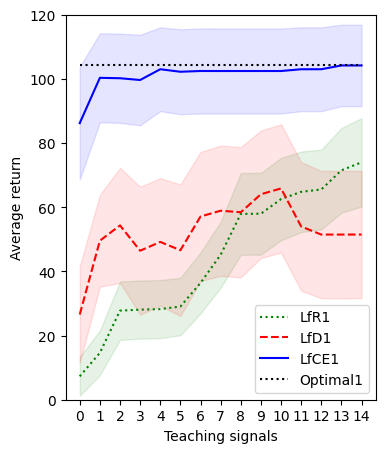

In [63]:
# Plot
plt.figure(figsize=(4, 5))
plt.fill_between(range(NSTEPS), rl_mean + rl_std, rl_mean - rl_std, color='g', alpha=0.1)
plt.fill_between(range(NSTEPS), demo_mean + demo_std, demo_mean - demo_std, color='r', alpha=0.1)
plt.fill_between(range(NSTEPS), expl_mean + expl_std, expl_mean - expl_std, color='b', alpha=0.1)
plt.plot(range(NSTEPS), rl_mean, 'g:', label='LfR1')
plt.plot(range(NSTEPS), demo_mean, 'r--', label='LfD1')
plt.plot(range(NSTEPS), expl_mean, 'b-', label='LfCE1')
plt.plot(range(NSTEPS), ref_mean, 'k:', label='Optimal1')
#plt.xlabel('N. samples')
#plt.ylabel(r'$||V_\pi||_2$')
plt.xlabel('Teaching signals')
plt.ylabel('Average return')
plt.ylim(0, 120)
plt.xticks(range(0, 15))
plt.legend(loc='best')
plt.show()

# **Approach 2**
The learner update the weights only if the reward, demonstration or explanation is relevant.

In [65]:
# Simulation constants
NRUNS = 30
NSTEPS = 15

# For performance statistics
perf_rl   = np.zeros((NRUNS, NSTEPS))
perf_demo = np.zeros((NRUNS, NSTEPS))
perf_expl = np.zeros((NRUNS, NSTEPS))
perf_ref  = np.zeros((NRUNS, NSTEPS))

# For reproducibility
np.random.seed(40)

# Run sims
for run in trange(NRUNS):

    # Initialize a random reward
    wopt = np.random.randn(len(RFEAT))
    ropt = np.sum([wopt[i] * RFEAT[i] for i in range(len(RFEAT))], axis=0)

    # This is the "target" MDP
    Mopt = (S, A, P, ropt, gamma)

    # Optimal policy
    popt = greedy(vi(Mopt))

    # Weights for 3 approaches
    w_rl   = np.zeros(len(RFEAT))
    w_demo = np.zeros(len(RFEAT))
    w_expl = np.zeros(len(RFEAT))

    samples_expl = []
    samples_demos = []
    samples_rl = []

    # Collecting demos
    expert_rewards = []
    expert_demonstrations = []
    expert_explanations = []

    # Run test
    for t in range(NSTEPS):
        # Sample a reward and update if more informative
        (s, a, r) = sample_reward(Mopt)
        expert_rewards.append((s, a, r))

        # Evaluate current performance
        current_perf = evaluate_reward(Mopt, w_rl)

        # Temporarily update and evaluate
        new_w_rl = rl_update(w_rl.copy(), s, a, r)
        new_perf = evaluate_reward(Mopt, new_w_rl)

        # Update weights if new information is more informative
        if new_perf > current_perf:
            w_rl = new_w_rl

        # Store performance
        perf_rl[run, t] = evaluate_reward(Mopt, w_rl)
        samples_rl.append(perf_rl[run, t])

        # Sample a demo and update if more informative
        (s, a) = sample_demo(Mopt)
        expert_demonstrations.append((s, a))

        current_perf = evaluate_reward(Mopt, w_demo)

        new_w_demo = demo_update(w_demo.copy(), s, a)
        new_perf = evaluate_reward(Mopt, new_w_demo)

        if new_perf > current_perf:
            w_demo = new_w_demo

        perf_demo[run, t] = evaluate_reward(Mopt, w_demo)
        samples_demos.append(perf_demo[run, t])

        # Sample a contrastive example and update if more informative
        (s0, s1, a0, a1, k) = sample_explain(Mopt)
        expert_explanations.append((s0, s1, a0, a1, k))

        current_perf = evaluate_reward(Mopt, w_expl)

        new_w_expl = explain_update(w_expl.copy(), s0, s1, a0, a1, k)
        new_perf = evaluate_reward(Mopt, new_w_expl)

        if new_perf > current_perf:
            w_expl = new_w_expl

        perf_expl[run, t] = evaluate_reward(Mopt, w_expl)
        samples_expl.append(perf_expl[run, t])

        perf_ref[run, t] = evaluate_reward(Mopt, wopt)

        print('Done. Step complete.')

# Compute statistics
rl_mean_2 = np.mean(perf_rl, axis=0)
rl_std_2 = np.std(perf_rl, axis=0) / np.sqrt(NRUNS)

demo_mean_2 = np.mean(perf_demo, axis=0)
demo_std_2 = np.std(perf_demo, axis=0) / np.sqrt(NRUNS)

expl_mean_2 = np.mean(perf_expl, axis=0)
expl_std_2 = np.std(perf_expl, axis=0) / np.sqrt(NRUNS)

ref_mean_2 = np.mean(perf_ref, axis=0)

  0%|          | 0/30 [00:00<?, ?it/s]

12
2
-0.034408627405261356
9
1
Done. Step complete.
14
4
-0.03832162007531013
8
1
Done. Step complete.
13
2
0.4629269416588988
11
1
Done. Step complete.
9
3
-0.655020128141129
11
1
Done. Step complete.
2
0
-0.7661188324640122
12
1
Done. Step complete.
2
0
-0.7109900523216924
11
1
Done. Step complete.
2
3
-0.5836576387161814
9
1
Done. Step complete.
10
1
1.003993174691577
13
0
Done. Step complete.
16
0
0.10501256825718175
10
2
Done. Step complete.
18
1
0.2519075530269076
4
1
Done. Step complete.
9
4
-0.7158987066660757
1
3
Done. Step complete.
3
2
0.23245177379883858
1
3
Done. Step complete.
15
0
-0.22502654143430703
14
3
Done. Step complete.
0
0
0.12634370016708824
16
3
Done. Step complete.
18
1
-0.022390211479049862
12
1


  3%|▎         | 1/30 [00:25<12:22, 25.60s/it]

Done. Step complete.
10
3
-0.9840742835522331
7
0
Done. Step complete.
2
1
1.2230372876713296
6
0
Done. Step complete.
11
4
0.35386999183412904
8
3
Done. Step complete.
5
2
-0.008976720862355948
8
3
Done. Step complete.
5
4
-0.1404109860865329
5
1
Done. Step complete.
6
4
0.45570444903705587
5
1
Done. Step complete.
7
4
0.009150969025691081
14
0
Done. Step complete.
5
2
-0.11610140492197314
18
2
Done. Step complete.
3
1
-0.06045740628703955
15
2
Done. Step complete.
3
3
0.0380057228100457
5
1
Done. Step complete.
16
2
0.009266203646563052
7
0
Done. Step complete.
15
3
-0.23611387560986336
13
1
Done. Step complete.
4
2
0.2856164629207326
2
2
Done. Step complete.
2
0
0.44864316935376736
8
4
Done. Step complete.
5
3
-0.0013113080356119782
13
1


  7%|▋         | 2/30 [01:04<15:28, 33.16s/it]

Done. Step complete.
8
0
-0.06289239194204474
7
1
Done. Step complete.
15
4
0.025558175520097492
3
3
Done. Step complete.
10
2
1.139340928344634
18
0
Done. Step complete.
10
4
1.1114426302106595
14
4
Done. Step complete.
11
1
-0.19685960606313418
17
3
Done. Step complete.
14
4
0.18339585215105084
0
3
Done. Step complete.
13
3
0.024339749391710106
8
0
Done. Step complete.
7
1
0.2635096500575391
14
3
Done. Step complete.
15
4
0.01546932668665918
11
1
Done. Step complete.
6
4
-0.3773912044606974
2
3
Done. Step complete.
13
2
0.05284570766027484
11
1
Done. Step complete.
4
4
-0.06038962101656782
1
3
Done. Step complete.
13
3
0.08494980337260485
11
1
Done. Step complete.
10
3
0.8789363503742798
3
3
Done. Step complete.
10
0
0.9679928454926997
12
1


 10%|█         | 3/30 [01:31<13:40, 30.39s/it]

Done. Step complete.
6
4
-0.23800872651918317
16
0
Done. Step complete.
18
3
-0.2585801858012432
2
0
Done. Step complete.
7
3
0.055531711992962196
11
0
Done. Step complete.
5
2
0.1992588521578364
16
0
Done. Step complete.
0
4
-0.08958606683209568
18
0
Done. Step complete.
5
2
0.5064858305348829
17
2
Done. Step complete.
2
1
1.3425027506460148
9
0
Done. Step complete.
4
1
0.0695710238393023
8
0
Done. Step complete.
2
0
1.1178104625482184
5
0
Done. Step complete.
3
0
0.38090755563410106
11
0
Done. Step complete.
8
0
-0.3093814335001599
3
2
Done. Step complete.
12
2
0.034891021488114196
16
0
Done. Step complete.
3
2
-0.2411368272817367
8
0
Done. Step complete.
14
4
-0.13454436251673024
13
0
Done. Step complete.
1
3
0.2632752704094824
18
0


 13%|█▎        | 4/30 [01:56<12:19, 28.42s/it]

Done. Step complete.
8
1
1.090678855893366
7
0
Done. Step complete.
16
2
0.27131722848652645
7
0
Done. Step complete.
0
2
-0.001200206483210652
15
2
Done. Step complete.
3
4
-0.1544659833347111
13
1
Done. Step complete.
7
2
-0.2871829816966205
4
2
Done. Step complete.
10
4
0.18996317573835703
6
0
Done. Step complete.
17
4
0.056360151894732716
12
1
Done. Step complete.
9
4
-0.8402370276047552
16
2
Done. Step complete.
8
2
0.7458853218563368
1
2
Done. Step complete.
17
0
-0.04987419971091307
5
1
Done. Step complete.
3
0
0.3730364730631176
11
0
Done. Step complete.
12
2
0.04948228157882138
17
2
Done. Step complete.
0
4
-0.1770374726712211
0
1
Done. Step complete.
9
3
-0.8607883873642397
12
1
Done. Step complete.
17
4
0.26586368495709206
3
2


 17%|█▋        | 5/30 [02:22<11:31, 27.67s/it]

Done. Step complete.
8
1
-0.7700327150524555
18
0
Done. Step complete.
6
0
0.053819101332498766
14
3
Done. Step complete.
4
0
-0.05401796391232412
13
0
Done. Step complete.
17
4
-0.2136704492484937
16
3
Done. Step complete.
3
1
0.04430375591627108
11
1
Done. Step complete.
7
0
-0.18303958940567103
0
3
Done. Step complete.
7
1
0.09357181415779825
0
3
Done. Step complete.
4
2
0.18212939497977393
10
3
Done. Step complete.
16
3
0.09127846603320991
5
0
Done. Step complete.
18
0
0.16078923592702407
10
4
Done. Step complete.
3
4
-0.07295596422518341
16
3
Done. Step complete.
1
0
0.004988926313542397
6
0
Done. Step complete.
2
2
-0.5191187232771304
14
3
Done. Step complete.
16
4
-0.19274949779666029
0
3
Done. Step complete.
1
1
-0.04763171604953489
16
3


 20%|██        | 6/30 [02:45<10:26, 26.10s/it]

Done. Step complete.
6
2
-0.058096451535658136
18
2
Done. Step complete.
8
4
0.9455035234231468
15
3
Done. Step complete.
1
0
0.2647244083914373
0
3
Done. Step complete.
3
0
0.03071287223858542
17
2
Done. Step complete.
1
4
-0.025765058895525078
1
3
Done. Step complete.
1
1
0.015450259474018185
3
2
Done. Step complete.
15
2
-0.04917567666134888
5
0
Done. Step complete.
9
1
2.042075648284167
13
0
Done. Step complete.
17
4
0.003543863413303034
16
0
Done. Step complete.
13
3
-0.18813595166497954
14
3
Done. Step complete.
18
2
-0.10743970690064093
18
2
Done. Step complete.
5
2
-0.6054364491677022
4
1
Done. Step complete.
10
1
1.5769712925964974
3
2
Done. Step complete.
3
2
0.18379161027820967
12
0
Done. Step complete.
11
1
0.42038867805646357
8
1


 23%|██▎       | 7/30 [03:12<10:05, 26.33s/it]

Done. Step complete.
7
2
-0.2818563136353235
15
3
Done. Step complete.
3
0
-0.1001868192427449
9
0
Done. Step complete.
2
0
1.4288397349379922
10
0
Done. Step complete.
16
1
-0.19140040426283694
16
0
Done. Step complete.
10
3
-0.09030456907808457
0
3
Done. Step complete.
10
2
0.7374436112859848
12
0
Done. Step complete.
13
0
0.1926222637046141
2
4
Done. Step complete.
4
2
0.09700482056442193
5
0
Done. Step complete.
3
0
-0.019236475147209994
16
0
Done. Step complete.
13
1
-0.31442258226017117
14
0
Done. Step complete.
11
3
0.1112400849876817
13
0
Done. Step complete.
15
0
0.27334597453730003
16
0
Done. Step complete.
7
1
0.22864830738666067
7
0
Done. Step complete.
15
3
-0.05797920456797008
8
0
Done. Step complete.
4
1
0.29375796350632477
10
0


 27%|██▋       | 8/30 [03:39<09:44, 26.58s/it]

Done. Step complete.
6
0
-0.0548675292178733
17
3
Done. Step complete.
18
1
0.29459833904016325
17
3
Done. Step complete.
11
3
-0.11703353884262344
0
3
Done. Step complete.
13
1
0.07516814430981447
5
1
Done. Step complete.
1
1
0.17809349331569851
13
0
Done. Step complete.
17
1
-0.019320245196283017
8
1
Done. Step complete.
10
0
1.1746148423601421
1
3
Done. Step complete.
13
2
0.21448963663120996
16
3
Done. Step complete.
0
0
-0.28057049027576525
3
3
Done. Step complete.
9
3
-0.9080743443607936
6
0
Done. Step complete.
16
1
0.03880004339004835
2
3
Done. Step complete.
18
1
0.4463412576745256
6
0
Done. Step complete.
2
2
-1.5190450963811144
5
0
Done. Step complete.
6
4
-0.013508981497029888
10
2
Done. Step complete.
1
0
-0.35435012302553287
10
3


 30%|███       | 9/30 [04:05<09:11, 26.24s/it]

Done. Step complete.
2
0
1.607388835647476
0
3
Done. Step complete.
15
2
0.14613872909364348
8
0
Done. Step complete.
8
4
-0.1460413407697213
11
0
Done. Step complete.
15
1
0.10593525354800486
17
2
Done. Step complete.
8
3
-0.3924552200350731
13
0
Done. Step complete.
12
3
0.2559626746268199
9
0
Done. Step complete.
13
3
-0.03643547169375044
14
3
Done. Step complete.
7
1
-0.180467964772231
8
0
Done. Step complete.
14
0
0.12414595739305123
13
0
Done. Step complete.
12
4
-0.21960539338365445
13
0
Done. Step complete.
6
3
0.04320107660246268
15
3
Done. Step complete.
5
4
0.1999928257948313
1
3
Done. Step complete.
18
2
-0.25675121768326925
14
3
Done. Step complete.
13
1
0.17281570066250368
12
0
Done. Step complete.
8
0
0.10396410997845114
2
0


 33%|███▎      | 10/30 [04:34<08:59, 26.98s/it]

Done. Step complete.
14
1
-0.03123143557463325
5
0
Done. Step complete.
8
4
-0.8501867492364599
1
3
Done. Step complete.
18
1
0.10282755162536956
11
0
Done. Step complete.
6
2
0.1784357439130972
10
0
Done. Step complete.
13
1
0.27322644371007593
11
0
Done. Step complete.
6
3
-0.08270024063689788
4
2
Done. Step complete.
0
4
-0.18326869308641355
10
0
Done. Step complete.
16
4
0.2269124262327018
17
0
Done. Step complete.
16
2
0.002777892917341992
12
0
Done. Step complete.
7
2
-0.257337814466353
14
0
Done. Step complete.
17
0
-0.3786810345989603
8
0
Done. Step complete.
2
4
0.4355175300310173
17
2
Done. Step complete.
17
4
-0.1383297161876939
11
0
Done. Step complete.
16
1
-0.1008439747609017
2
4
Done. Step complete.
4
1
0.04741400093799822
0
0


 37%|███▋      | 11/30 [04:55<07:58, 25.18s/it]

Done. Step complete.
8
0
-0.9878939037675643
1
1
Done. Step complete.
0
1
0.13603659946860672
6
4
Done. Step complete.
3
3
0.008364885690675923
18
0
Done. Step complete.
7
0
0.06702907989165678
10
0
Done. Step complete.
9
2
-0.35809661032994855
10
3
Done. Step complete.
2
4
0.23017537952719713
3
3
Done. Step complete.
18
3
-0.1430534593740697
15
3
Done. Step complete.
13
2
0.1567894868180571
6
4
Done. Step complete.
4
0
-0.1916545118400996
2
4
Done. Step complete.
7
1
0.3867578959892866
2
2
Done. Step complete.
9
1
-0.10934616243943782
5
4
Done. Step complete.
12
4
0.1481146339975947
17
1
Done. Step complete.
16
2
-0.24507981735558607
0
3
Done. Step complete.
1
3
-0.19482844035779429
2
2
Done. Step complete.
14
3
-0.09084792597821775
4
1


 40%|████      | 12/30 [05:19<07:29, 24.97s/it]

Done. Step complete.
11
4
0.14079613525372145
5
3
Done. Step complete.
12
2
-0.26540973327729883
5
4
Done. Step complete.
6
0
-0.02632492005551006
2
3
Done. Step complete.
15
1
0.001491949745306697
5
3
Done. Step complete.
14
0
0.27703286674549565
0
4
Done. Step complete.
16
1
-0.058405804352975155
14
1
Done. Step complete.
2
2
-0.23627065675871495
3
2
Done. Step complete.
10
4
-0.5556132347321056
16
0
Done. Step complete.
1
1
-0.027609823432021164
1
3
Done. Step complete.
5
1
0.031172655791204124
6
1
Done. Step complete.
3
1
-0.2855385144819587
10
1
Done. Step complete.
2
3
-0.25989290293074613
4
0
Done. Step complete.
8
2
-2.4412103923189115
9
2
Done. Step complete.
7
4
-0.0021613656412527897
5
0
Done. Step complete.
9
2
-0.11815693478538003
5
2


 43%|████▎     | 13/30 [05:36<06:24, 22.64s/it]

Done. Step complete.
3
1
0.26330676461935865
18
2
Done. Step complete.
11
0
0.243206357134711
10
1
Done. Step complete.
9
3
1.6590649865950275
8
1
Done. Step complete.
11
1
-0.28200966951989637
4
2
Done. Step complete.
12
1
-0.0994493882732713
11
1
Done. Step complete.
14
0
0.1600546708477792
11
1
Done. Step complete.
0
4
0.10495640699338608
14
3
Done. Step complete.
17
3
-0.04840245216026917
9
4
Done. Step complete.
18
2
0.12243949126687723
0
3
Done. Step complete.
7
3
-0.027383764106335355
15
3
Done. Step complete.
13
4
0.11358780446256736
7
0
Done. Step complete.
5
0
-0.00974725538648322
14
3
Done. Step complete.
8
2
0.9672919951765628
3
2
Done. Step complete.
16
0
-0.10746548296620921
4
2
Done. Step complete.
0
3
0.3870193152490817
15
3


 47%|████▋     | 14/30 [06:02<06:14, 23.43s/it]

Done. Step complete.
3
0
0.1568177251745772
13
2
Done. Step complete.
7
1
-0.31979412468255186
1
2
Done. Step complete.
14
4
-0.0017750368397026102
16
4
Done. Step complete.
13
4
-0.16940161839442267
8
0
Done. Step complete.
14
1
-0.22942834826619243
15
1
Done. Step complete.
5
3
0.22030161328574271
4
4
Done. Step complete.
10
3
-0.5368287316454318
18
3
Done. Step complete.
12
4
0.22325890130556295
12
4
Done. Step complete.
15
1
0.0347351907333137
15
1
Done. Step complete.
18
2
0.3457091021918005
1
4
Done. Step complete.
18
1
-0.06182131006191419
1
0
Done. Step complete.
5
2
-0.15358245166900106
3
1
Done. Step complete.
14
0
0.048915962779693005
11
2
Done. Step complete.
7
3
-0.06474708388097464
4
2
Done. Step complete.
4
4
-0.12523902062390485
14
3


 50%|█████     | 15/30 [06:06<04:26, 17.75s/it]

Done. Step complete.
7
4
0.009696354390739913
6
0
Done. Step complete.
13
2
-0.45529971036260736
3
2
Done. Step complete.
16
0
-0.08321421214433887
17
2
Done. Step complete.
16
0
-0.09966749732714089
13
0
Done. Step complete.
15
3
-0.04820837759564053
17
2
Done. Step complete.
8
0
-1.2282730404846818
3
2
Done. Step complete.
1
3
0.053278876945753714
17
2
Done. Step complete.
2
3
0.6554196878333811
10
0
Done. Step complete.
11
2
-0.13691061191696927
18
2
Done. Step complete.
7
3
-0.2889042913100842
15
3
Done. Step complete.
10
2
-0.987351750103966
15
3
Done. Step complete.
10
2
-0.9913453402814462
13
0
Done. Step complete.
18
0
0.001956027499696147
10
0
Done. Step complete.
3
2
-0.3058015336238914
18
2
Done. Step complete.
14
1
0.033875092940337484
5
0


 53%|█████▎    | 16/30 [06:32<04:41, 20.09s/it]

Done. Step complete.
13
1
0.07910979695505242
7
2
Done. Step complete.
12
3
0.22098813586484972
11
4
Done. Step complete.
1
0
-0.020403570460903235
11
1
Done. Step complete.
6
3
0.04915450310016317
14
1
Done. Step complete.
3
1
0.16987659844923358
10
1
Done. Step complete.
4
2
-0.31094283478050244
6
3
Done. Step complete.
9
0
-0.5642504433374165
13
4
Done. Step complete.
15
1
-0.13846258623066515
7
2
Done. Step complete.
4
3
-0.21549048576998503
16
0
Done. Step complete.
12
0
0.2846568630698326
16
3
Done. Step complete.
14
3
-0.21348197332604127
1
0
Done. Step complete.
5
0
0.3917390961736045
11
2
Done. Step complete.
1
0
-0.06757413122457087
1
1
Done. Step complete.
4
3
-0.4267340645110672
14
4
Done. Step complete.
2
2
-0.6537221714639453
3
4


 57%|█████▋    | 17/30 [06:36<03:19, 15.36s/it]

Done. Step complete.
12
0
0.06458297936940645
4
2
Done. Step complete.
7
3
-0.05027532308400991
17
2
Done. Step complete.
15
1
-0.1948490180236655
5
1
Done. Step complete.
11
2
0.07552954128158537
3
2
Done. Step complete.
17
3
-0.05550030464670983
0
1
Done. Step complete.
16
4
-0.244927613162983
12
1
Done. Step complete.
13
4
0.0026867383959279256
10
1
Done. Step complete.
11
0
0.03335927134880677
4
2
Done. Step complete.
8
3
2.4926024176539108
13
1
Done. Step complete.
7
3
-0.4666558242291819
9
1
Done. Step complete.
11
3
-0.03848194588318974
6
0
Done. Step complete.
18
3
-0.061104891098309966
2
2
Done. Step complete.
2
1
-1.16720719900216
16
2
Done. Step complete.
16
4
0.12800342114124216
1
2
Done. Step complete.
16
4
0.413550893172105
6
0


 60%|██████    | 18/30 [07:00<03:36, 18.02s/it]

Done. Step complete.
1
4
-0.1993345058448608
16
0
Done. Step complete.
2
4
-1.7495340919182218
7
0
Done. Step complete.
6
2
-0.035188770467189365
15
3
Done. Step complete.
18
2
0.1555066016687183
11
1
Done. Step complete.
6
0
0.2107591428923677
4
2
Done. Step complete.
12
0
-0.36207875970442954
17
2
Done. Step complete.
12
2
0.07288012070239688
15
3
Done. Step complete.
4
0
-0.1324427909920644
11
1
Done. Step complete.
17
0
0.4881148325764807
4
2
Done. Step complete.
6
0
-0.2534222458260766
8
1
Done. Step complete.
5
1
-0.26701818434050456
7
0
Done. Step complete.
7
0
-0.11570724258922364
18
2
Done. Step complete.
14
3
0.14721616537677734
13
1
Done. Step complete.
10
3
2.3429357576533785
16
0
Done. Step complete.
9
3
2.7496820422828034
4
2


 63%|██████▎   | 19/30 [07:22<03:30, 19.09s/it]

Done. Step complete.
1
1
-0.12931991416175262
5
2
Done. Step complete.
0
2
-0.01637673094310185
0
1
Done. Step complete.
4
0
-0.19522561657853338
4
3
Done. Step complete.
11
1
0.020841775628261595
16
1
Done. Step complete.
5
2
0.38076144535615514
11
4
Done. Step complete.
2
3
-1.8393832609073313
14
4
Done. Step complete.
9
0
-0.6900899970792718
14
4
Done. Step complete.
4
4
-0.20290689327754854
0
3
Done. Step complete.
11
4
-0.16011857997555584
1
1
Done. Step complete.
11
3
0.3940634472802427
14
3
Done. Step complete.
4
3
-0.17169732493996426
7
3
Done. Step complete.
0
0
-0.0008262311513669649
6
4
Done. Step complete.
6
3
0.25159790133253407
14
4
Done. Step complete.
1
4
-0.2378134895747599
3
3
Done. Step complete.
8
2
-1.6058764961414407
2
3


 67%|██████▋   | 20/30 [07:26<02:25, 14.60s/it]

Done. Step complete.
5
3
-0.08354339412398208
10
2
Done. Step complete.
9
2
0.2110870762995306
18
0
Done. Step complete.
12
3
-0.024115873201679534
7
1
Done. Step complete.
8
0
-0.09968711348305745
13
0
Done. Step complete.
5
3
-0.028280283945860685
4
1
Done. Step complete.
4
4
-0.1651503680231721
15
3
Done. Step complete.
15
1
0.027740877462900253
10
2
Done. Step complete.
11
0
-0.13300401407949075
13
0
Done. Step complete.
5
1
-0.539649871657623
8
0
Done. Step complete.
2
1
0.6549132463224364
4
1
Done. Step complete.
14
3
-0.1451103803170105
10
2
Done. Step complete.
13
3
0.0827639408939169
0
3
Done. Step complete.
4
0
-0.23415643782390855
9
2
Done. Step complete.
13
3
-0.0838543335205089
18
0
Done. Step complete.
15
1
0.48166993178869244
4
1


 70%|███████   | 21/30 [07:53<02:45, 18.35s/it]

Done. Step complete.
0
3
0.12323672482276675
4
3
Done. Step complete.
12
0
0.378883156930247
7
4
Done. Step complete.
2
0
-0.7328886709881163
7
2
Done. Step complete.
2
0
-0.47476846994153654
4
0
Done. Step complete.
2
4
-0.6430339635012028
3
0
Done. Step complete.
2
4
-0.4633736981098127
4
3
Done. Step complete.
16
1
-0.21074125595819612
6
3
Done. Step complete.
0
4
0.0819001329724318
9
0
Done. Step complete.
11
1
-0.23864483127070932
17
4
Done. Step complete.
2
0
-0.567859265035853
0
1
Done. Step complete.
11
1
-0.3506561309117323
4
1
Done. Step complete.
12
2
-0.1060961039083842
5
2
Done. Step complete.
8
4
-1.4714569257022854
2
2
Done. Step complete.
3
4
-0.4149635831366688
9
1
Done. Step complete.
9
2
-1.7762198559138371
1
0


 73%|███████▎  | 22/30 [07:59<01:55, 14.47s/it]

Done. Step complete.
16
0
-0.08981923336454942
7
0
Done. Step complete.
10
1
-1.9720007091071314
7
0
Done. Step complete.
4
3
-0.35643191836423305
11
0
Done. Step complete.
10
3
-2.09657477148835
12
1
Done. Step complete.
15
2
-0.03151239465342289
10
0
Done. Step complete.
14
1
-0.3400101521688162
6
0
Done. Step complete.
3
3
0.05501268277832614
18
2
Done. Step complete.
16
2
0.19031507207943754
3
2
Done. Step complete.
3
3
-0.06619908760323888
13
1
Done. Step complete.
16
2
-0.10791097338484719
4
2
Done. Step complete.
8
0
1.4947596580081488
8
4
Done. Step complete.
15
3
0.18093499362006457
0
1
Done. Step complete.
0
2
0.15521159211433863
3
2
Done. Step complete.
6
3
-0.18302653797663332
7
0
Done. Step complete.
7
2
-0.20544470843518825
12
1


 77%|███████▋  | 23/30 [08:21<01:58, 16.86s/it]

Done. Step complete.
0
3
-0.6765401274636609
7
0
Done. Step complete.
3
3
-0.12259839656788858
18
2
Done. Step complete.
1
4
0.21698870028698553
0
1
Done. Step complete.
15
1
-0.01988902563602502
1
2
Done. Step complete.
5
0
-0.11948867085917617
11
0
Done. Step complete.
12
2
0.023960208228924817
12
1
Done. Step complete.
4
4
0.3181719072139275
18
2
Done. Step complete.
14
4
-0.22420637909833557
1
2
Done. Step complete.
16
4
-0.16224818706152858
16
2
Done. Step complete.
12
0
-0.17358917971851956
1
2
Done. Step complete.
10
3
-0.055154957020226034
4
2
Done. Step complete.
15
3
-0.07789179499393467
8
3
Done. Step complete.
4
1
0.01862952717280782
6
0
Done. Step complete.
4
3
0.133934111774124
2
2
Done. Step complete.
16
4
-0.05370046490015905
10
1


 80%|████████  | 24/30 [08:41<01:47, 17.93s/it]

Done. Step complete.
3
1
0.054951489850621725
7
1
Done. Step complete.
18
3
-0.07682215885093827
9
1
Done. Step complete.
15
2
0.05815619293324879
18
0
Done. Step complete.
3
0
0.04371655729327744
10
2
Done. Step complete.
15
4
-0.20808027697751613
1
3
Done. Step complete.
18
4
0.10711475183380928
9
1
Done. Step complete.
15
3
0.2518426265789522
17
3
Done. Step complete.
11
3
-0.09522167414480591
16
3
Done. Step complete.
0
1
-0.10218243408544585
18
0
Done. Step complete.
4
4
-0.14048752188603597
13
0
Done. Step complete.
3
1
-0.03438345075977897
3
3
Done. Step complete.
18
4
0.1309942918949239
17
3
Done. Step complete.
12
2
0.16338912569213898
3
3
Done. Step complete.
13
3
-0.036350445200100764
6
0
Done. Step complete.
14
4
0.2335187214811608
7
1


 83%|████████▎ | 25/30 [09:03<01:35, 19.15s/it]

Done. Step complete.
7
3
-0.22686359880371407
1
3
Done. Step complete.
12
1
0.18067519885939734
7
3
Done. Step complete.
8
0
0.617991855154702
8
0
Done. Step complete.
3
0
0.16128108569395216
10
0
Done. Step complete.
15
2
-0.057043695827792174
2
4
Done. Step complete.
6
3
-0.04351453012933097
4
2
Done. Step complete.
16
2
0.13302300493042102
11
0
Done. Step complete.
7
2
0.07073853213453349
13
0
Done. Step complete.
11
0
-0.1860609341930693
13
0
Done. Step complete.
9
2
0.22702635828485396
4
2
Done. Step complete.
1
4
-0.18722315043540264
14
0
Done. Step complete.
12
0
-0.22813283177744265
1
3
Done. Step complete.
3
0
0.050387952596917404
13
0
Done. Step complete.
16
3
0.012822867567815945
17
2
Done. Step complete.
18
0
0.014756137250214916
13
0


 87%|████████▋ | 26/30 [09:30<01:25, 21.40s/it]

Done. Step complete.
11
0
-0.15804750311229082
2
0
Done. Step complete.
16
0
0.0943977203314632
6
0
Done. Step complete.
5
3
-0.22830361674506644
9
0
Done. Step complete.
0
4
-0.1093331919830269
16
0
Done. Step complete.
4
2
-0.413483413757363
9
0
Done. Step complete.
15
2
-0.3101045698199078
14
1
Done. Step complete.
3
1
-0.15926167547111333
18
2
Done. Step complete.
14
1
-0.1465603770502007
4
2
Done. Step complete.
1
2
-0.17812490385050195
8
0
Done. Step complete.
3
0
0.035945764918287416
8
4
Done. Step complete.
16
1
0.0769910134903494
7
0
Done. Step complete.
18
0
-0.11600870835210705
3
2
Done. Step complete.
0
0
0.1121279325001296
13
0
Done. Step complete.
6
3
0.043984526169383725
13
0
Done. Step complete.
7
3
0.008931262852802043
14
0


 90%|█████████ | 27/30 [09:52<01:04, 21.65s/it]

Done. Step complete.
16
0
0.25887116915828706
9
0
Done. Step complete.
9
1
-1.5594656868461327
11
0
Done. Step complete.
9
1
-1.3258949911510725
1
3
Done. Step complete.
0
1
-0.18665438916335075
13
0
Done. Step complete.
4
2
-0.16784433058643372
7
0
Done. Step complete.
0
0
0.039388394247292194
3
2
Done. Step complete.
1
2
0.12577002560564962
15
3
Done. Step complete.
1
0
-0.2021093756585312
17
2
Done. Step complete.
6
0
-0.10931461065626509
18
2
Done. Step complete.
6
1
0.014402358424976617
16
0
Done. Step complete.
0
3
0.08313713925954183
0
3
Done. Step complete.
4
1
-0.04508075081689661
3
2
Done. Step complete.
13
3
0.15701703321980937
8
0
Done. Step complete.
11
1
-0.08008083679200968
14
0
Done. Step complete.
12
0
-0.019825146066317127
12
0


 93%|█████████▎| 28/30 [10:15<00:43, 21.84s/it]

Done. Step complete.
17
3
0.02265640314982122
1
3
Done. Step complete.
17
1
0.055222508105584614
2
3
Done. Step complete.
16
4
-0.3813395008021906
5
0
Done. Step complete.
11
2
0.3728178069261384
1
3
Done. Step complete.
17
3
-0.006018062969884453
3
3
Done. Step complete.
12
1
0.040368678964117694
5
0
Done. Step complete.
15
4
-0.32524727697578304
17
3
Done. Step complete.
12
0
0.27849165631963335
4
1
Done. Step complete.
9
1
2.330915530333548
17
3
Done. Step complete.
12
3
0.22731524900034214
2
3
Done. Step complete.
0
2
0.057116647830065904
11
1
Done. Step complete.
18
4
-0.13726695356348922
14
3
Done. Step complete.
16
2
0.002603060266226526
4
1
Done. Step complete.
6
2
0.12148905645818267
10
4
Done. Step complete.
7
1
-0.01427110340106696
9
4


 97%|█████████▋| 29/30 [10:39<00:22, 22.69s/it]

Done. Step complete.
5
0
-0.2774742015598143
11
1
Done. Step complete.
0
2
0.013216260435200258
3
3
Done. Step complete.
16
1
0.3277847979307706
0
3
Done. Step complete.
9
3
-1.0292369333071687
5
0
Done. Step complete.
1
3
0.28616493665976195
5
0
Done. Step complete.
1
2
0.3440117685264571
11
1
Done. Step complete.
11
1
-0.19163031584891316
0
3
Done. Step complete.
6
2
-0.285511515993251
15
3
Done. Step complete.
4
4
-0.1127097260703764
2
0
Done. Step complete.
11
0
-0.2752266633173911
10
3
Done. Step complete.
13
1
-0.2094623039011431
7
1
Done. Step complete.
17
3
-0.1766361099181517
10
2
Done. Step complete.
16
2
-0.18180811425814775
0
3
Done. Step complete.
8
2
0.2541327232390824
16
3
Done. Step complete.
12
3
0.2916960168688812
17
3


100%|██████████| 30/30 [11:01<00:00, 22.06s/it]

Done. Step complete.


In [32]:
expert_rewards

[(5, 0, -0.2774742015598143),
 (0, 2, 0.013216260435200258),
 (16, 1, 0.3277847979307706),
 (9, 3, -1.0292369333071687),
 (1, 3, 0.28616493665976195),
 (1, 2, 0.3440117685264571),
 (11, 1, -0.19163031584891316),
 (6, 2, -0.285511515993251),
 (4, 4, -0.1127097260703764),
 (11, 0, -0.2752266633173911),
 (13, 1, -0.2094623039011431),
 (17, 3, -0.1766361099181517),
 (16, 2, -0.18180811425814775),
 (8, 2, 0.2541327232390824),
 (12, 3, 0.2916960168688812)]

In [36]:
expert_demonstrations

[(11, 1),
 (3, 3),
 (0, 3),
 (5, 0),
 (5, 0),
 (11, 1),
 (0, 3),
 (15, 3),
 (2, 0),
 (10, 3),
 (7, 1),
 (10, 2),
 (0, 3),
 (16, 3),
 (17, 3)]

In [37]:
expert_explanations

[(14, 10, 3, 0, 1),
 (11, 10, 1, 0, 1),
 (6, 10, 0, 1, 1),
 (16, 10, 3, 1, 1),
 (13, 10, 0, 4, 1),
 (1, 10, 3, 0, 1),
 (7, 10, 1, 0, 1),
 (9, 10, 0, 1, 1),
 (2, 10, 3, 0, 1),
 (3, 10, 3, 0, 1),
 (1, 10, 3, 1, 1),
 (14, 10, 3, 1, 1),
 (5, 10, 0, 1, 1),
 (15, 10, 3, 4, 1),
 (6, 9, 1, 3, -1)]

In [38]:
samples_expl

[82.29851066343026,
 82.29851066343026,
 82.29851066343026,
 82.29851066343026,
 82.29851066343026,
 82.29851066343026,
 82.29851066343026,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339]

In [39]:
samples_demos

[82.34743273778683,
 82.34743273778683,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339,
 82.39635481214339]

In [40]:
samples_rl

[3.95343359247816,
 3.95343359247816,
 3.95343359247816,
 10.305091033594506,
 10.305091033594506,
 10.305091033594506,
 10.305091033594506,
 10.305091033594506,
 10.305091033594506,
 10.305091033594506,
 10.305091033594506,
 10.305091033594506,
 10.305091033594506,
 18.520448131392154,
 18.520448131392154]

In [68]:
rl_min_2 = np.min(rl_mean_2, axis=0)
rl_range_2 = np.max(rl_mean_2, axis=0) - np.min(rl_mean, axis=0)
rl_norm_2 = (rl_mean_2 - rl_min_2)/rl_range_2
rl_normstd_2 = np.std(rl_norm_2, axis=0) / np.sqrt(NRUNS)

demo_min_2 = np.min(demo_mean_2, axis=0)
demo_range_2 = np.max(demo_mean_2, axis=0) - np.min(demo_mean_2, axis=0)
demo_norm_2 = (demo_mean_2 - demo_min_2)/demo_range_2
demo_normstd_2 = np.std(demo_norm_2, axis=0) / np.sqrt(NRUNS)

expl_min_2 = np.min(expl_mean_2, axis=0)
expl_range_2 = np.max(expl_mean_2, axis=0) - np.min(expl_mean_2, axis=0)
expl_norm_2 = (expl_mean_2 - expl_min_2)/expl_range_2
expl_normstd_2 = np.std(expl_norm_2, axis=0) / np.sqrt(NRUNS)


ref_min_2 = np.min(ref_mean_2)
ref_range_2 = np.max(ref_mean_2) - np.min(ref_mean_2)
ref_norm_2 = (ref_mean_2 - ref_min_2)/ref_range_2

<ipython-input-68-cd22d9c44287>:19: RuntimeWarning: divide by zero encountered in divide
  ref_norm_2 = (ref_mean_2 - ref_min_2)/ref_range_2
<ipython-input-68-cd22d9c44287>:19: RuntimeWarning: invalid value encountered in divide
  ref_norm_2 = (ref_mean_2 - ref_min_2)/ref_range_2


<ipython-input-72-8c29bcf4f898>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(range(NSTEPS), rl_mean_2, 'g-', label='LfR2', color='green')
<ipython-input-72-8c29bcf4f898>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(NSTEPS), demo_mean_2, 'r--', label='LfD2', color='orange')
<ipython-input-72-8c29bcf4f898>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(NSTEPS), expl_mean_2, 'b-', label='LfCE2', color='purple')
<ipython-input-72-8c29bcf4f898>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt

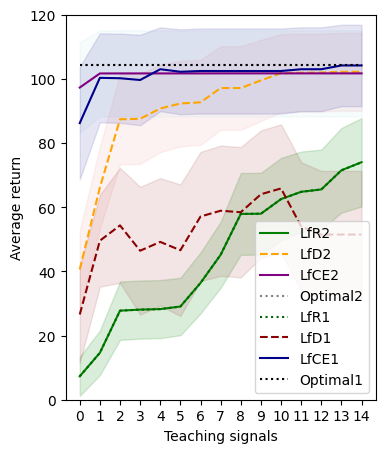

In [72]:
# Plot
plt.figure(figsize=(4, 5))

# Approach 2
plt.fill_between(range(NSTEPS), rl_mean_2 + rl_std_2, rl_mean_2 - rl_std_2, color='lightgreen', alpha=0.1)
plt.fill_between(range(NSTEPS), demo_mean_2 + demo_std_2, demo_mean_2 - demo_std_2, color='lightcoral', alpha=0.1)
plt.fill_between(range(NSTEPS), expl_mean_2 + expl_std_2, expl_mean_2 - expl_std_2, color='lightblue', alpha=0.1)
plt.plot(range(NSTEPS), rl_mean_2, 'g-', label='LfR2', color='green')
plt.plot(range(NSTEPS), demo_mean_2, 'r--', label='LfD2', color='orange')
plt.plot(range(NSTEPS), expl_mean_2, 'b-', label='LfCE2', color='purple')
plt.plot(range(NSTEPS), ref_mean_2, 'k:', label='Optimal2', color='gray')

# Approach 1
plt.fill_between(range(NSTEPS), rl_mean + rl_std, rl_mean - rl_std, color='darkgreen', alpha=0.1)
plt.fill_between(range(NSTEPS), demo_mean + demo_std, demo_mean - demo_std, color='darkred', alpha=0.1)
plt.fill_between(range(NSTEPS), expl_mean + expl_std, expl_mean - expl_std, color='darkblue', alpha=0.1)
plt.plot(range(NSTEPS), rl_mean, 'g:', label='LfR1', color='darkgreen')
plt.plot(range(NSTEPS), demo_mean, 'r--', label='LfD1', color='darkred')
plt.plot(range(NSTEPS), expl_mean, 'b-', label='LfCE1', color='darkblue')
plt.plot(range(NSTEPS), ref_mean, 'k:', label='Optimal1', color='black')

# Labels and legend
plt.xlabel('Teaching signals')
plt.ylabel('Average return')
plt.ylim(0, 120)
plt.xticks(range(0, 15))
plt.legend(loc='best')
plt.show()


# **Approach 3**
We use BEC to evaluate the expert rewards, demonstrations and explanations.

In [59]:
# Import necessary libraries
import numpy as np
from tqdm import trange

# Simulation constants
NRUNS = 30
NSTEPS = 15

# For performance statistics
perf_rl = np.zeros((NRUNS, NSTEPS))
perf_demo = np.zeros((NRUNS, NSTEPS))
perf_expl = np.zeros((NRUNS, NSTEPS))
perf_ref = np.zeros((NRUNS, NSTEPS))

# For reproducibility
np.random.seed(40)

def compute_BEC(policy, Mopt, feature_expectations):
    S, A, P, ropt, gamma = Mopt
    BEC = []

    for s in S:
        for a in A:
            mu_sa = feature_expectations[(s, a)]
            for a_prime in A:
                if a != a_prime:
                    mu_sa_prime = feature_expectations[(s, a_prime)]
                    half_space = np.dot(ropt, (mu_sa - mu_sa_prime)) >= 0
                    BEC.append(half_space)

    return BEC

def calculate_BEC_for_trajectory(trajectory, policy, feature_expectations):
    BEC_trajectory = []

    for (s, a, r) in trajectory:
        mu_sa = feature_expectations[(s, a)]
        for a_prime in policy[s]:
            if a != a_prime:
                mu_sa_prime = feature_expectations[(s, a_prime)]
                half_space = np.dot(ropt, (mu_sa - mu_sa_prime)) >= 0
                BEC_trajectory.append(half_space)

    return BEC_trajectory

def set_cover_greedy(U, T):
    C = set()
    D = set()

    while U - C:
        max_intersection = 0
        best_trajectory = None

        for tau in T:
            intersection = len(U.intersection(tau))
            if intersection > max_intersection:
                max_intersection = intersection
                best_trajectory = tau

        if best_trajectory:
            D.add(best_trajectory)
            C = C.union(best_trajectory)

    return D

def compute_feature_expectations(policy, Mopt):
    S, A, P, R, gamma = Mopt
    feature_expectations = { (s, a): np.zeros(len(RFEAT[next(iter(RFEAT))])) for s in S for a in A }

    for s in S:
        for a in A:
            discount_factor = 1.0
            state = s
            action = a

            for t in range(NSTEPS):
                feature_expectations[(s, a)] += discount_factor * RFEAT[state]

                # Move to the next state according to the policy
                next_state_probs = P[state][action]
                next_state = np.random.choice(list(next_state_probs.keys()), p=list(next_state_probs.values()))

                # Select the next action based on the policy
                action_probs = policy[next_state]
                action = np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

                # Update the discount factor
                discount_factor *= gamma

    return feature_expectations

# Main simulation loop
for run in trange(NRUNS):

    # Initialize a random reward
    num_features = len(RFEAT[next(iter(RFEAT))])
    wopt = np.random.randn(num_features)
    ropt = np.sum([wopt[i] * RFEAT[state][i] for state in RFEAT.keys() for i in range(num_features)], axis=0)

    # This is the "target" MDP
    Mopt = (S, A, P, ropt, gamma)

    # Optimal policy
    popt = greedy(vi(Mopt))

    # Compute feature expectations for optimal policy
    feature_expectations = compute_feature_expectations(popt, Mopt)

    # Use Theorem 1 to compute BEC
    BEC_popt = compute_BEC(popt, Mopt, feature_expectations)

    # Initialize sets for SCOT algorithm
    U = set(BEC_popt)
    T = []
    expert_rewards = []
    expert_demonstrations = []
    expert_explanations = []

    # Run test
    for t in range(NSTEPS):
        # Sample a reward and store
        (s, a, r) = sample_reward(Mopt)
        expert_rewards.append((s, a, r))

        # Sample a demo and store
        (s, a) = sample_demo(Mopt)
        expert_demonstrations.append((s, a))

        # Sample a contrastive example and store
        (s0, s1, a0, a1, k) = sample_explain(Mopt)
        expert_explanations.append((s0, s1, a0, a1, k))

        # Compute BEC for each type of expert information
        BEC_reward = calculate_BEC_for_trajectory([(s, a, r)], popt, feature_expectations)
        BEC_demo = calculate_BEC_for_trajectory([(s, a)], popt, feature_expectations)
        BEC_explain = calculate_BEC_for_trajectory([(s0, s1, a0, a1, k)], popt, feature_expectations)

        # Add to set of constraints
        T.extend([BEC_reward, BEC_demo, BEC_explain])

        # Perform SCOT algorithm
        D = set_cover_greedy(U, T)

        # Update weights based on the selected most informative examples
        for (s, a, r) in expert_rewards:
            if (s, a, r) in D:
                w_rl = rl_update(w_rl, s, a, r)

        for (s, a) in expert_demonstrations:
            if (s, a) in D:
                w_demo = demo_update(w_demo, s, a)

        for (s0, s1, a0, a1, k) in expert_explanations:
            if (s0, s1, a0, a1, k) in D:
                w_expl = explain_update(w_expl, s0, s1, a0, a1, k)

        # Evaluate performance
        perf_rl[run, t] = evaluate_reward(Mopt, w_rl)
        perf_demo[run, t] = evaluate_reward(Mopt, w_demo)
        perf_expl[run, t] = evaluate_reward(Mopt, w_expl)
        perf_ref[run, t] = evaluate_reward(Mopt, wopt)

        print('Done. Step complete.')

# Compute statistics
rl_mean = np.mean(perf_rl, axis=0)
rl_std = np.std(perf_rl, axis=0) / np.sqrt(NRUNS)

demo_mean = np.mean(perf_demo, axis=0)
demo_std = np.std(perf_demo, axis=0) / np.sqrt(NRUNS)

expl_mean = np.mean(perf_expl, axis=0)
expl_std = np.std(perf_expl, axis=0) / np.sqrt(NRUNS)

ref_mean = np.mean(perf_ref, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
rl_min = np.min(rl_mean, axis=0)
rl_range = np.max(rl_mean, axis=0) - np.min(rl_mean, axis=0)
rl_norm = (rl_mean - rl_min)/rl_range
rl_normstd = np.std(rl_norm, axis=0) / np.sqrt(NRUNS)

demo_min = np.min(demo_mean, axis=0)
demo_range = np.max(demo_mean, axis=0) - np.min(demo_mean, axis=0)
demo_norm = (demo_mean - demo_min)/demo_range
demo_normstd = np.std(demo_norm, axis=0) / np.sqrt(NRUNS)

expl_min = np.min(expl_mean, axis=0)
expl_range = np.max(expl_mean, axis=0) - np.min(expl_mean, axis=0)
expl_norm = (expl_mean - expl_min)/expl_range
expl_normstd = np.std(expl_norm, axis=0) / np.sqrt(NRUNS)


ref_min = np.min(ref_mean)
ref_range = np.max(ref_mean) - np.min(ref_mean)
ref_norm = (ref_mean - ref_min)/ref_range

<ipython-input-41-a6cb8b7f165e>:19: RuntimeWarning: divide by zero encountered in divide
  ref_norm = (ref_mean - ref_min)/ref_range
<ipython-input-41-a6cb8b7f165e>:19: RuntimeWarning: invalid value encountered in divide
  ref_norm = (ref_mean - ref_min)/ref_range


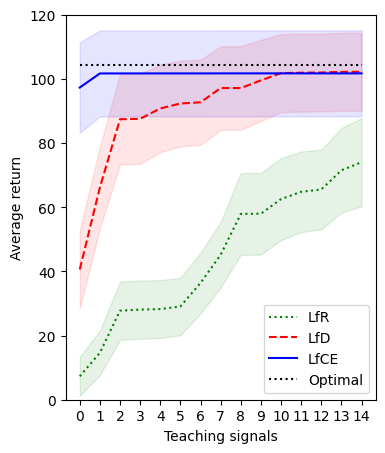

In [ ]:
# Plot
plt.figure(figsize=(4, 5))
plt.fill_between(range(NSTEPS), rl_mean + rl_std, rl_mean - rl_std, color='g', alpha=0.1)
plt.fill_between(range(NSTEPS), demo_mean + demo_std, demo_mean - demo_std, color='r', alpha=0.1)
plt.fill_between(range(NSTEPS), expl_mean + expl_std, expl_mean - expl_std, color='b', alpha=0.1)
plt.plot(range(NSTEPS), rl_mean, 'g:', label='LfR')
plt.plot(range(NSTEPS), demo_mean, 'r--', label='LfD')
plt.plot(range(NSTEPS), expl_mean, 'b-', label='LfCE')
plt.plot(range(NSTEPS), ref_mean, 'k:', label='Optimal')
#plt.xlabel('N. samples')
#plt.ylabel(r'$||V_\pi||_2$')
plt.xlabel('Teaching signals')
plt.ylabel('Average return')
plt.ylim(0, 120)
plt.xticks(range(0, 15))
plt.legend(loc='best')
plt.show()

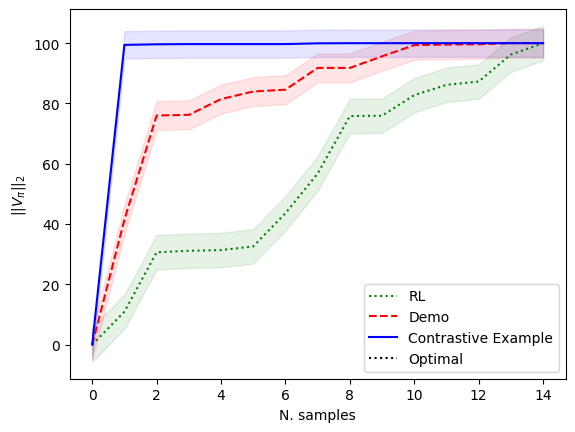

In [43]:
# Plot
plt.figure()
plt.fill_between(range(NSTEPS), rl_norm*100 + rl_normstd*100, rl_norm*100 - rl_normstd*100, color='g', alpha=0.1)
plt.fill_between(range(NSTEPS), demo_norm*100 + demo_normstd*100, demo_norm*100 - demo_normstd*100, color='r', alpha=0.1)
plt.fill_between(range(NSTEPS), expl_norm*100 + expl_normstd*100, expl_norm*100 - expl_normstd*100, color='b', alpha=0.1)
plt.plot(range(NSTEPS), rl_norm*100, 'g:', label='RL')
plt.plot(range(NSTEPS), demo_norm*100, 'r--', label='Demo')
plt.plot(range(NSTEPS), expl_norm*100, 'b-', label='Contrastive Example')
plt.plot(range(NSTEPS), ref_norm, 'k:', label='Optimal')
plt.xlabel('N. samples')
plt.ylabel(r'$||V_\pi||_2$')
plt.legend(loc='best')
plt.show()

In [44]:
print('Optimal:')
print(wopt)
print('Contrastive Examples:')
print(w_expl)
print('Demos:')
print(w_demo)
print('RL:')
print(w_rl)

Optimal:
[ 0.77400935  0.19217953 -1.08031784  0.86528134]
Contrastive Examples:
[ 0.0042135  -0.01617479  0.0039453   0.57847882]
Demos:
[ 9.58074360e-05 -2.26440269e-04  0.00000000e+00  1.41656361e-02]
RL:
[ 0.          0.05082654 -0.20584739  0.        ]


In [45]:
wopt = [ 0.77400935, 0.19217953, -1.08031784, 0.86528134]
w_expl = [ 0.00405971, -0.01627153, -0.50089822,  0.87839342]
w_demos = [-0.20741821, -0.01244667,  0.01091068,  0.05925187]
w_rl = [ 0.,0.05082654, -0.20584739, 0.        ]


In [ ]:
import scipy.stats
from scipy.stats import f_oneway
from scipy.stats import normaltest, ttest_rel, shapiro, mannwhitneyu, wilcoxon, ranksums, ttest_ind, kruskal, sem

In [ ]:
ttest_rel(perf_demo[5], perf_rl[5])

TtestResult(statistic=9.534616572884282, pvalue=1.6801336791089284e-07, df=14)

In [ ]:
mannwhitneyu(rl_mean,demo_mean)

MannwhitneyuResult(statistic=123.0, pvalue=0.6783024655972324)

In [ ]:
mannwhitneyu(rl_mean,expl_mean)

MannwhitneyuResult(statistic=0.0, pvalue=3.3833394126542183e-06)

In [ ]:
mannwhitneyu(demo_mean,expl_mean)

MannwhitneyuResult(statistic=0.0, pvalue=3.3833394126542183e-06)

In [ ]:
ttest_rel(rl_mean,demo_mean)

TtestResult(statistic=0.9274795151197749, pvalue=0.36939206304515015, df=14)

In [ ]:
ttest_rel(rl_mean,expl_mean)

TtestResult(statistic=-11.509656338736663, pvalue=1.5948655358133367e-08, df=14)

In [ ]:
ttest_rel(demo_mean,expl_mean)

TtestResult(statistic=-32.05173041281676, pvalue=1.673105598909057e-14, df=14)